# 1. Imports and Helper Functions

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import grad
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pylab import rcParams
import skvideo.io
import io
import base64
from IPython.display import HTML
rcParams['figure.figsize'] = 10, 10

/home/sungyub/.conda/envs/pytorch/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def sample_z(u, theta, eps=1e-20):
    return torch.log(theta+eps) - torch.log(-torch.log(u+eps)+eps)

def sample_zb(v, theta, b,ind, eps=1e-20):
    vk = torch.gather(v.view(-1,K), dim=1,index= ind * torch.ones(BATCH_SIZE*N,K).long().cuda())
#     print('vk')
#     print(vk[0])
#     print('1-b')
#     print((1-b)[:10])
    return - torch.log(-torch.log(vk.view(-1,1)+eps) \
                       + (1-b)*(-torch.log(v+eps)/(theta+eps)) +eps)
    
def H(x):
    ind = x.argmax(dim=1, keepdim=True)
    one_hot = torch.zeros_like(x)
    return one_hot.scatter(dim=1, index=ind, source=1), ind

# 2. Build Model

In [3]:
N= 30 # num of categorical distributions
K= 10 # size of categorical distributions

In [4]:
class en_Net(nn.Module):
    def __init__(self, ):
        super(en_Net, self).__init__()
        self.en1 = nn.Linear(784, 512)
        self.en1.weight.data.normal_(0, 0.1)   # initialization
        self.en2 = nn.Linear(512, 256)
        self.en2.weight.data.normal_(0, 0.1)   # initialization
        self.en3 = nn.Linear(256, N*K)
        self.en3.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = F.relu(self.en1(x))
        x = F.relu(self.en2(x))
        logits_y = self.en3(x)
        q_y = F.softmax(logits_y.view(-1,K)).view(-1,1)
            
        return q_y
    
class de_Net(nn.Module):
    def __init__(self, ):
        super(de_Net, self).__init__()
        self.de1 = nn.Linear(N*K, 256)
        self.de1.weight.data.normal_(0, 0.1)
        self.de2 = nn.Linear(256, 512)
        self.de2.weight.data.normal_(0, 0.1)
        self.de3 = nn.Linear(512, 784)
        self.de3.weight.data.normal_(0, 0.1)
        
    def forward(self, b):
        y = F.relu(self.de1(b))
        y = F.relu(self.de2(y))
        logits_x = self.de3(y)
        
        return logits_x

In [5]:
# get data
data = input_data.read_data_sets('/tmp/', one_hot=True).train

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
def compute_elbo(b, target, q_y):
    logits_x = de(b.view(-1,N*K))
    bce_loss = (F.binary_cross_entropy(F.sigmoid(logits_x) ,target,\
                                       reduce=False)).sum(dim=1)
    kl_reg = (q_y * (torch.log(q_y)-torch.log(torch.FloatTensor([1./K]).cuda()))).sum(dim=1)
    elbo = -bce_loss - kl_reg
    return elbo, logits_x

In [7]:
NUM_ITERS = 10**4
BATCH_SIZE = 100
LAMBDA = .1
ETA = 1.

In [8]:
en = en_Net().cuda()
de = de_Net().cuda()
en_opt = torch.optim.Adam(en.parameters(),lr=1e-3)
de_opt = torch.optim.Adam(de.parameters(),lr=1e-3)

/home/sungyub/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/home/sungyub/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:72: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


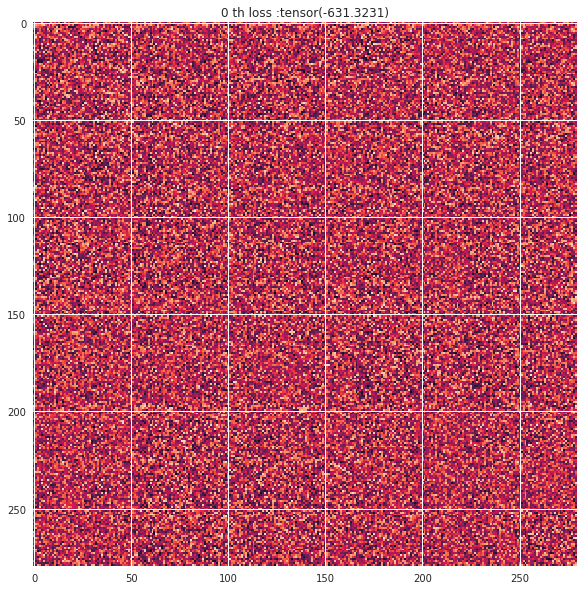

SF
tensor(-27418.9551, device='cuda:0')
PD
tensor(1.00000e-02 *
       4.8733, device='cuda:0')


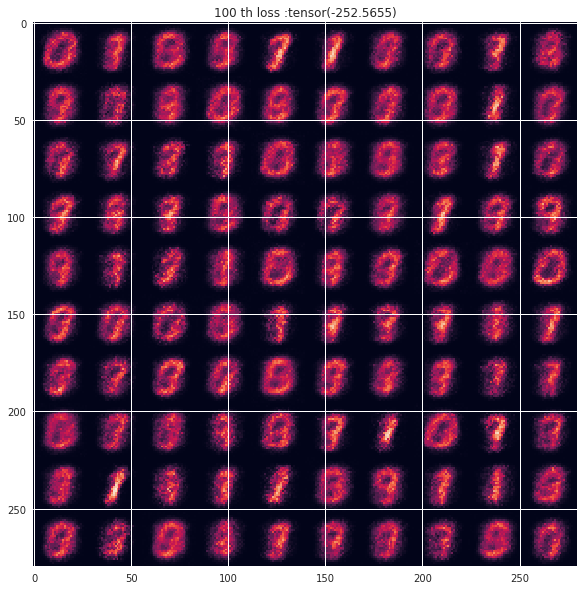

SF
tensor(-2341.8274, device='cuda:0')
PD
tensor(1.00000e-02 *
       9.2551, device='cuda:0')


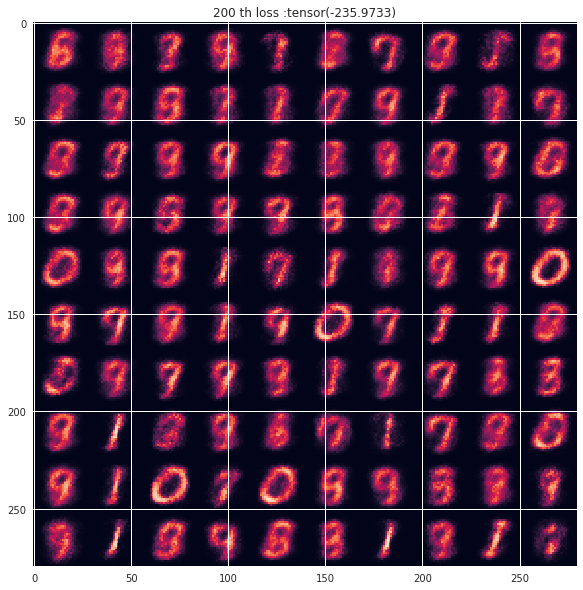

SF
tensor(-1686.7188, device='cuda:0')
PD
tensor(1.00000e-02 *
       -5.7723, device='cuda:0')


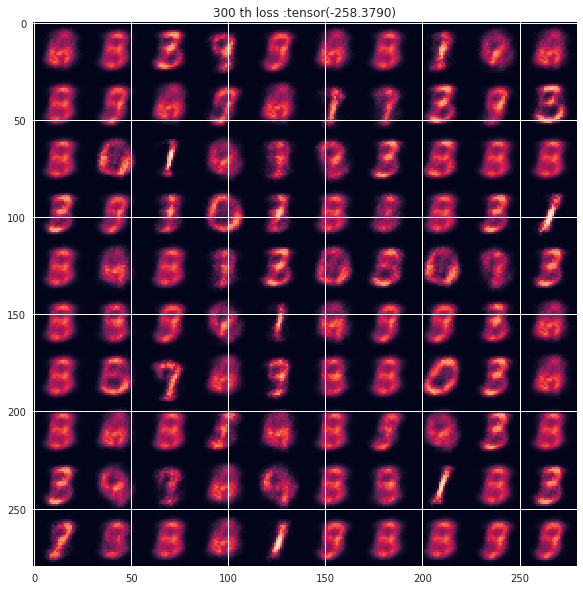

SF
tensor(-806.2645, device='cuda:0')
PD
tensor(1.00000e-02 *
       3.7977, device='cuda:0')


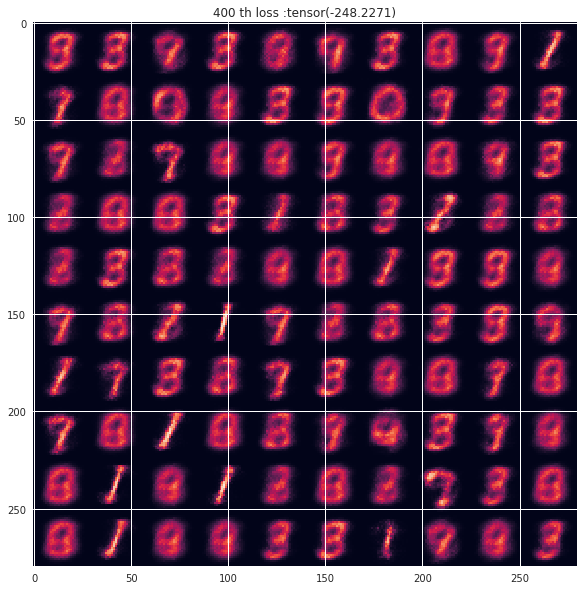

SF
tensor(-583.1233, device='cuda:0')
PD
tensor(-0.4535, device='cuda:0')


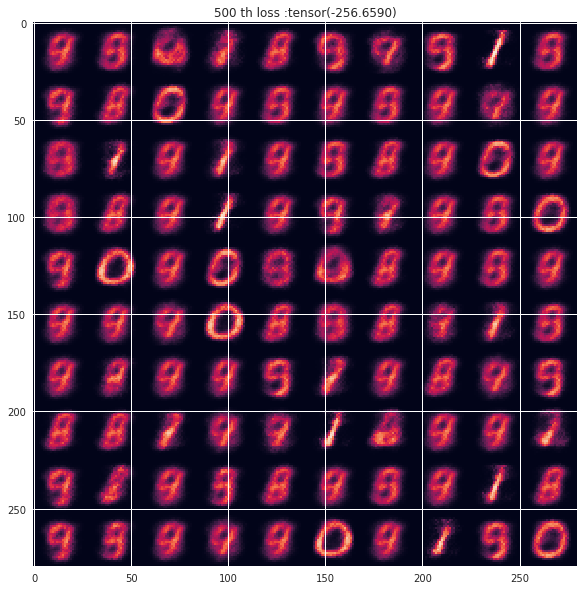

SF
tensor(-423.4283, device='cuda:0')
PD
tensor(-0.2265, device='cuda:0')


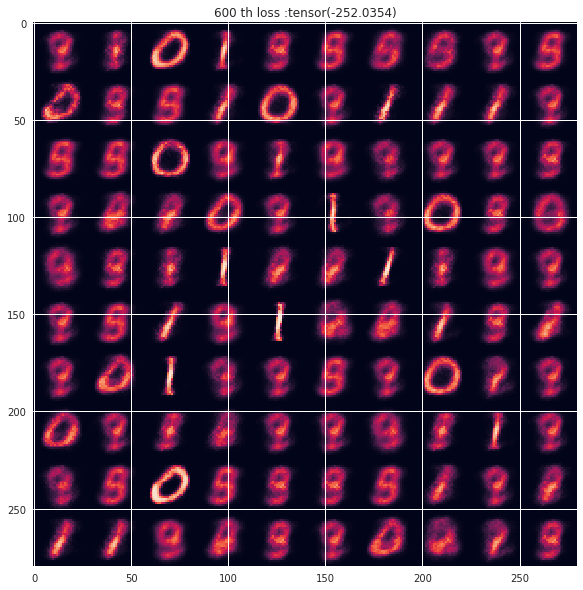

SF
tensor(-383.7288, device='cuda:0')
PD
tensor(-0.6687, device='cuda:0')


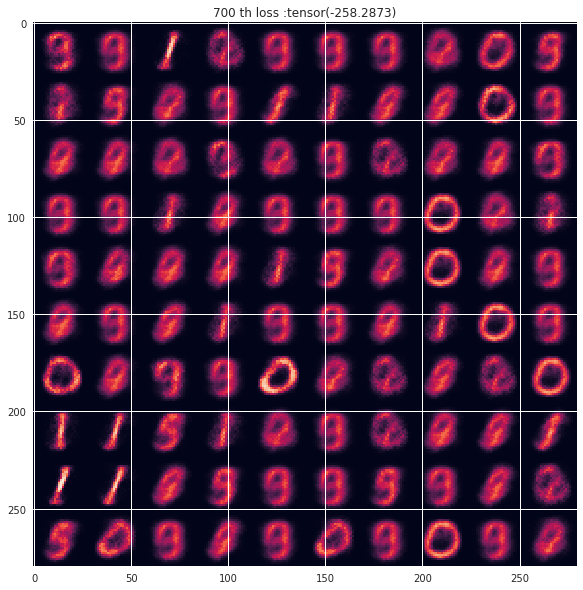

SF
tensor(-320.3366, device='cuda:0')
PD
tensor(0.1817, device='cuda:0')


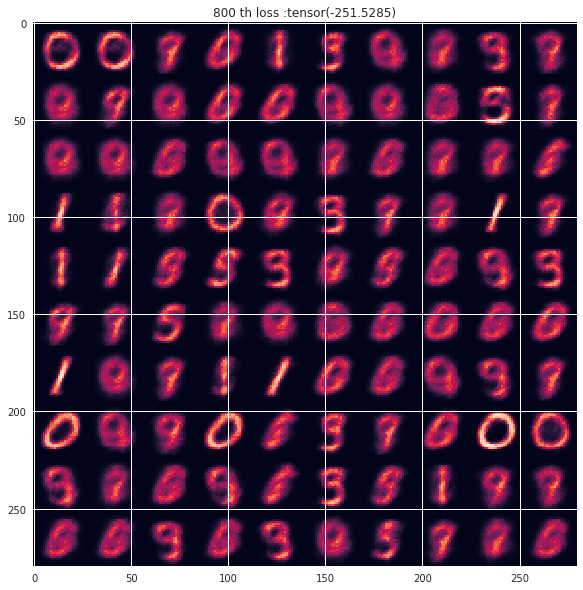

SF
tensor(-313.1750, device='cuda:0')
PD
tensor(0.3885, device='cuda:0')


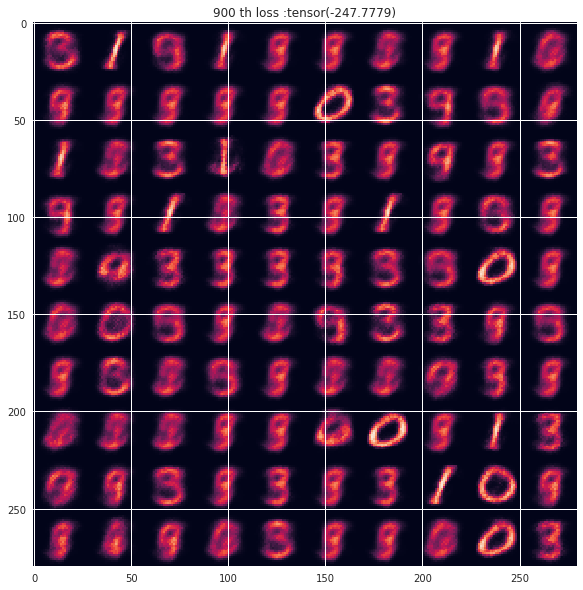

SF
tensor(-277.4114, device='cuda:0')
PD
tensor(0.1312, device='cuda:0')


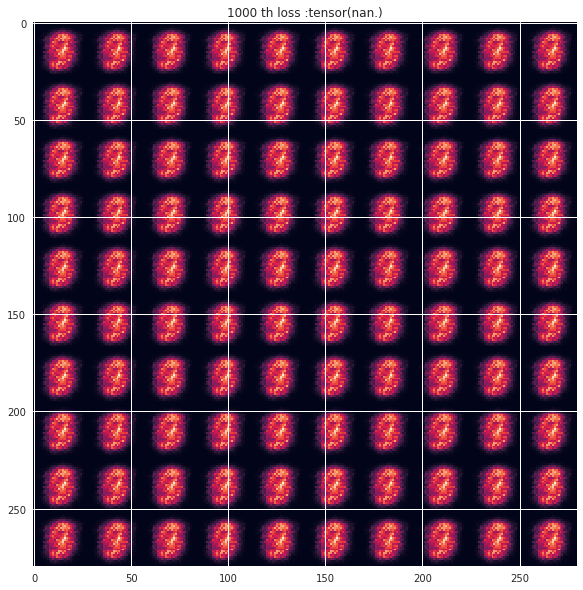

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


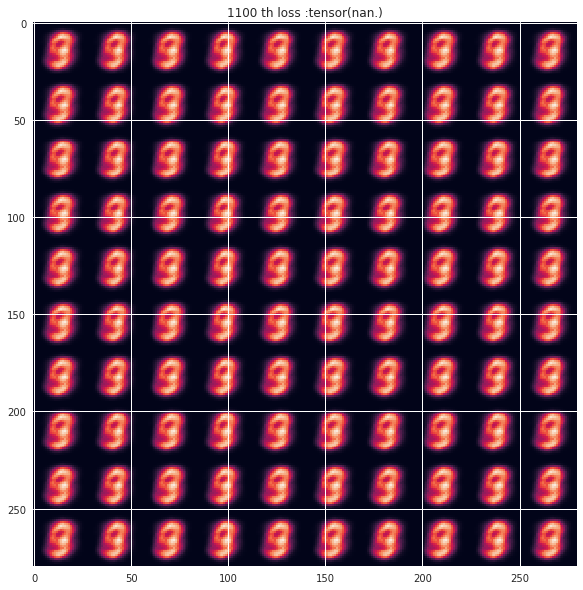

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


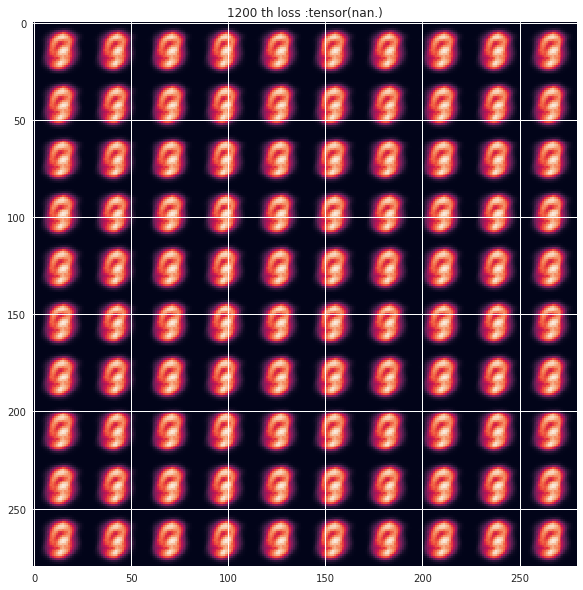

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


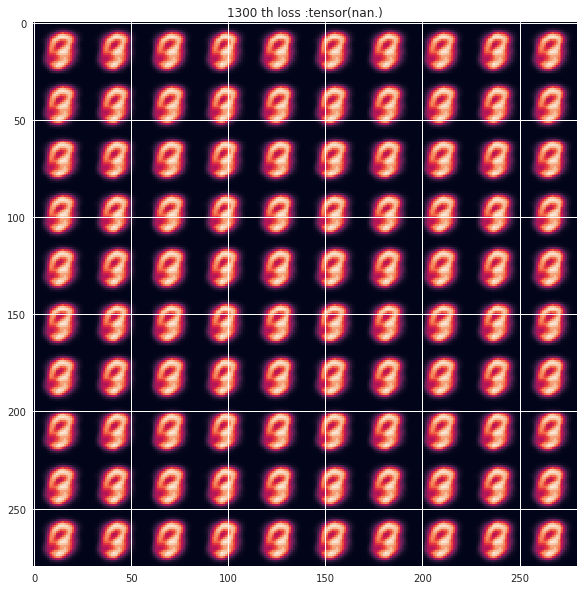

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


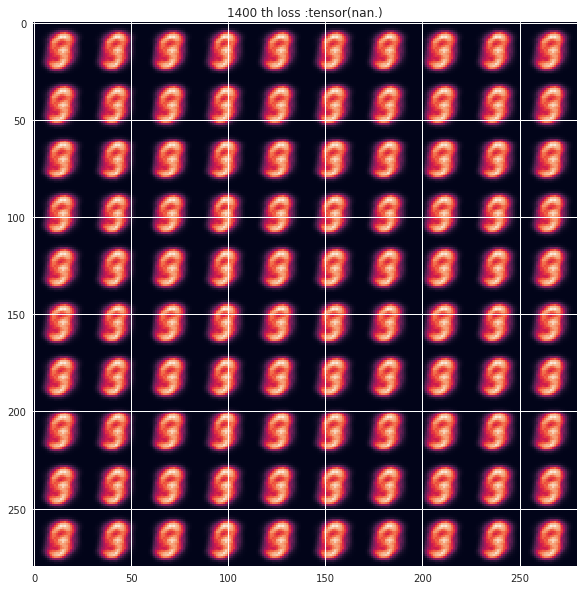

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


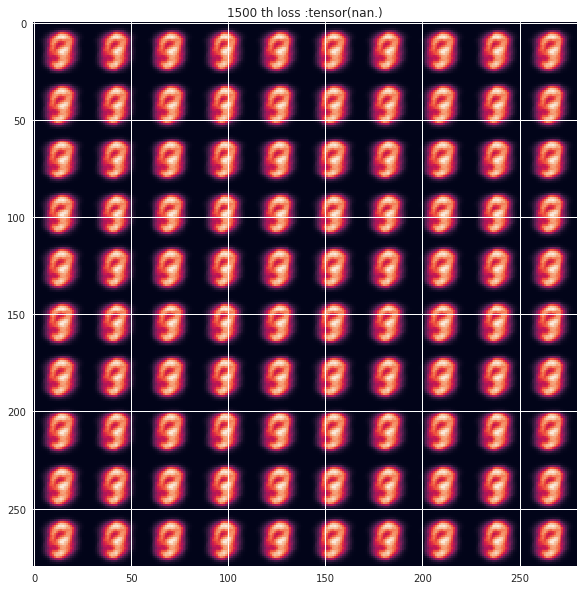

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


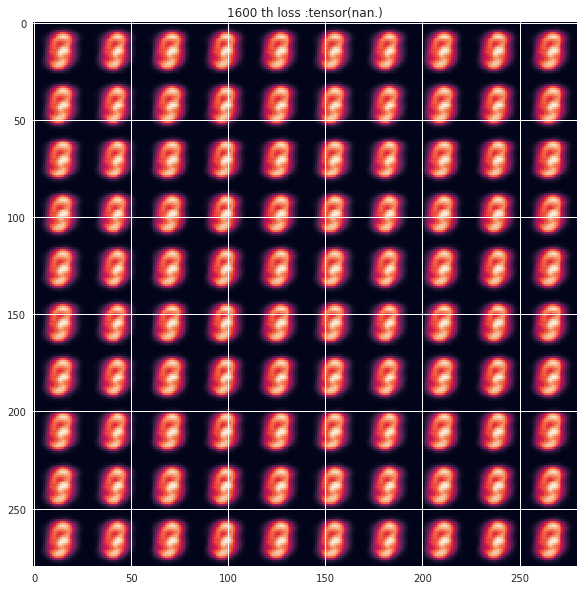

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


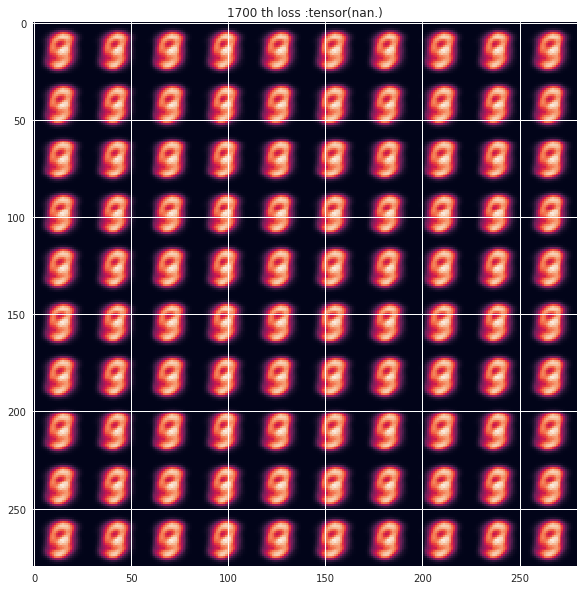

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


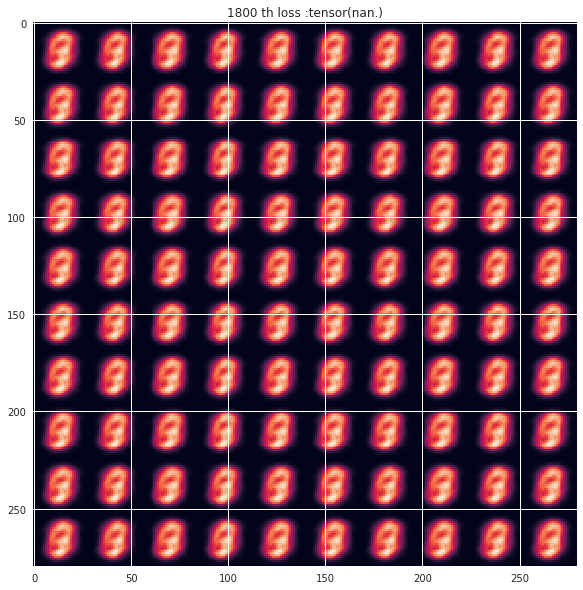

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


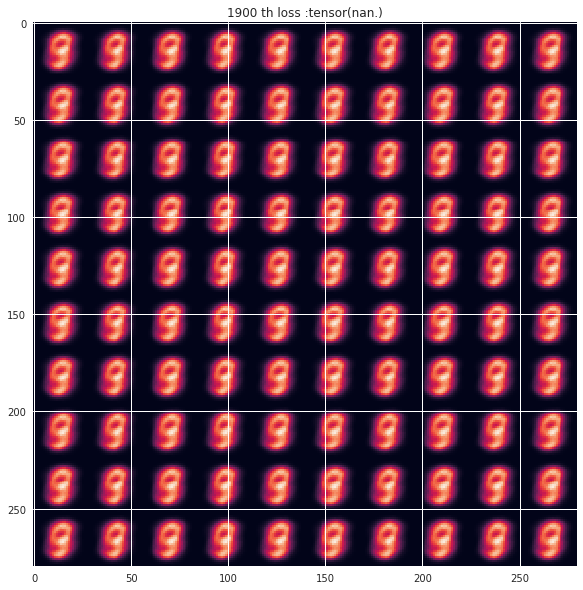

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


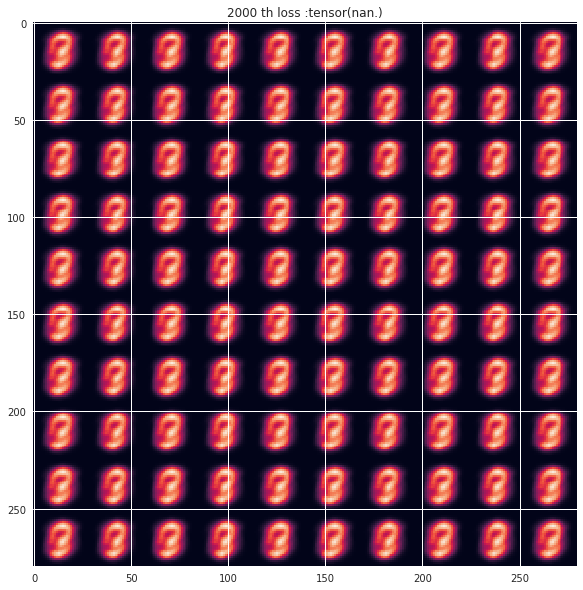

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


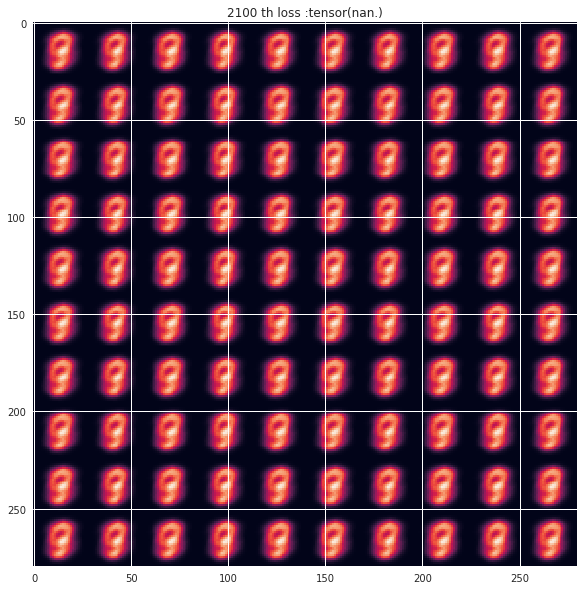

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


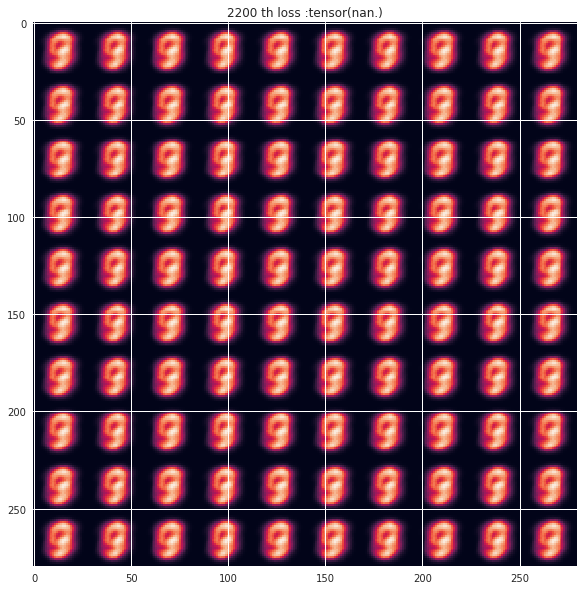

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


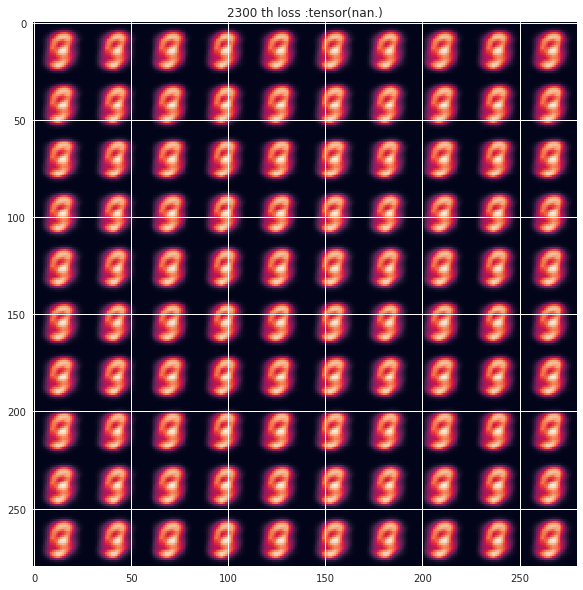

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


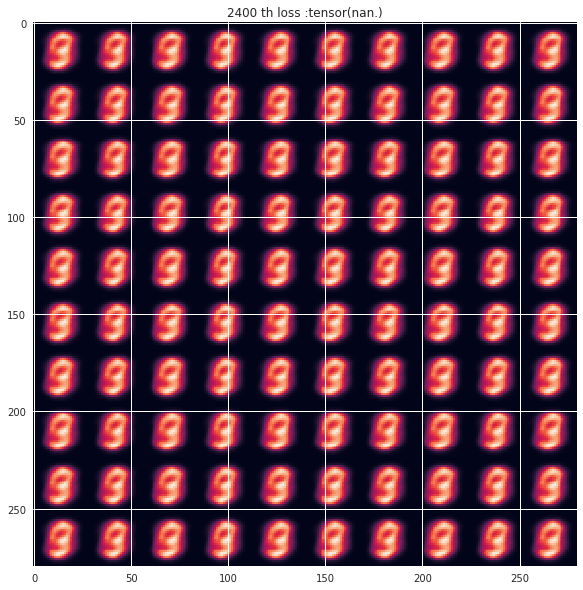

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


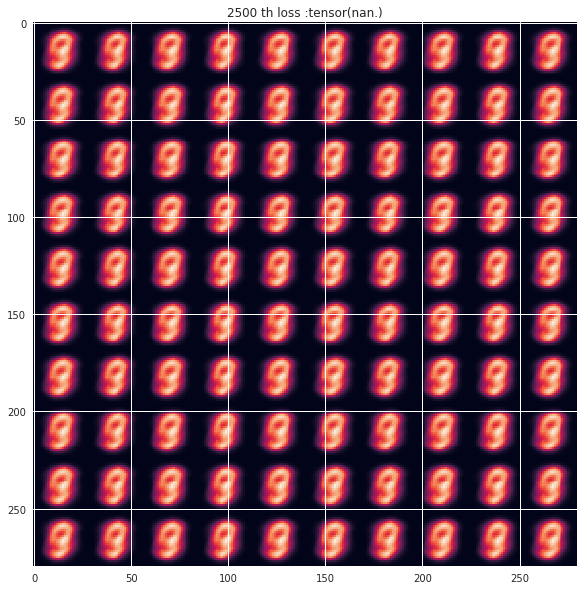

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


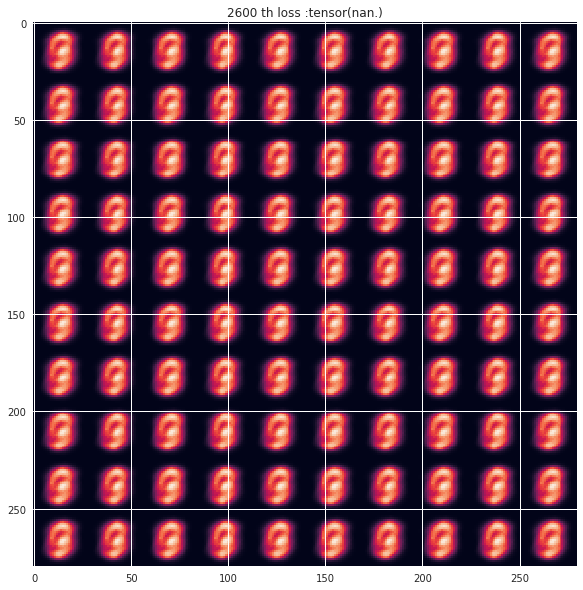

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


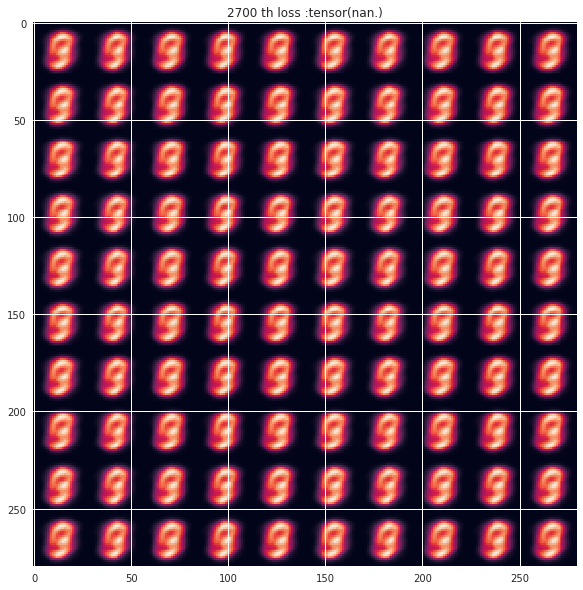

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


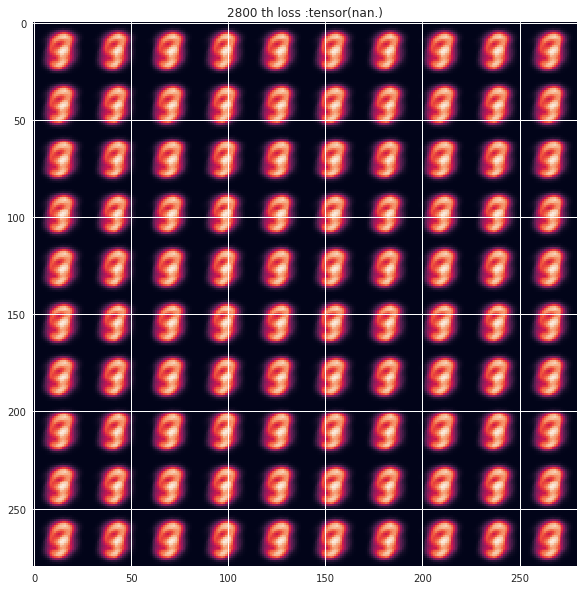

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


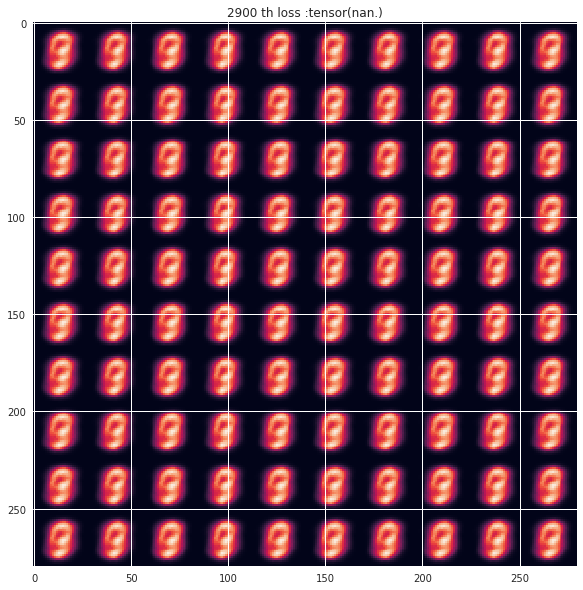

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


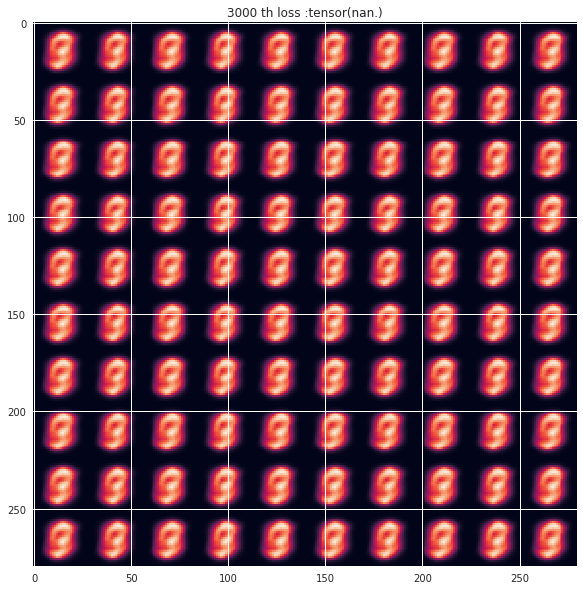

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


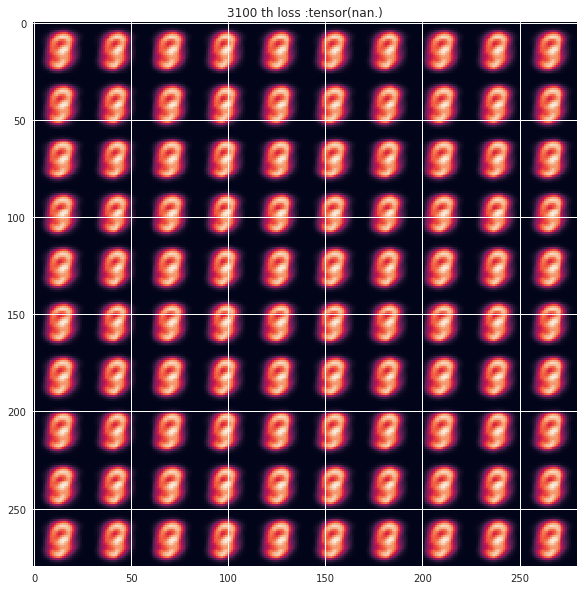

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


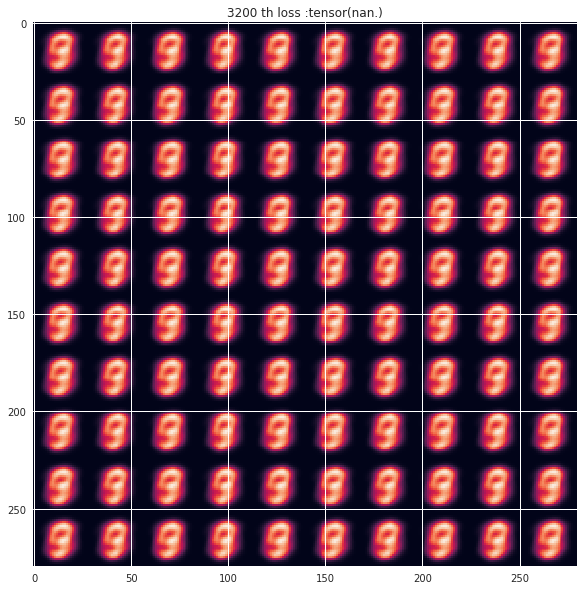

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


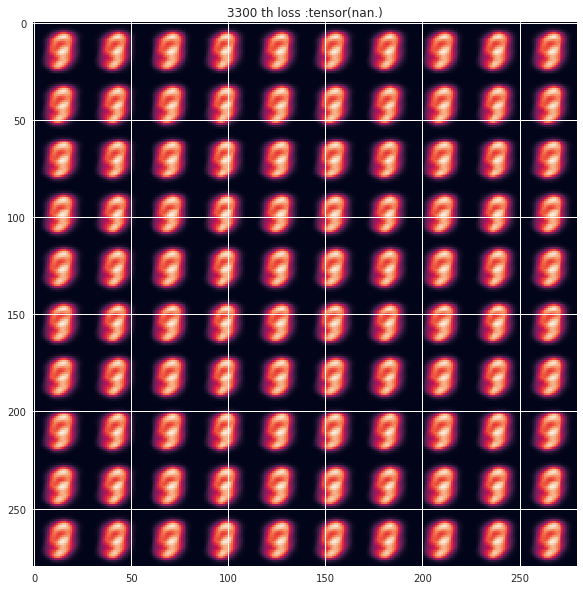

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


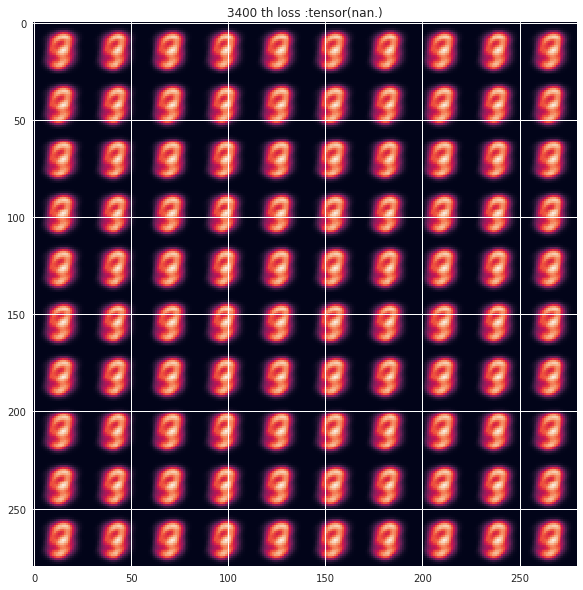

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


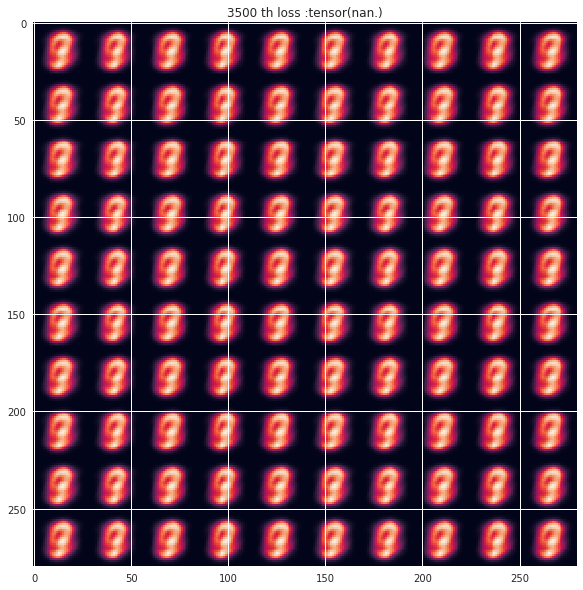

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


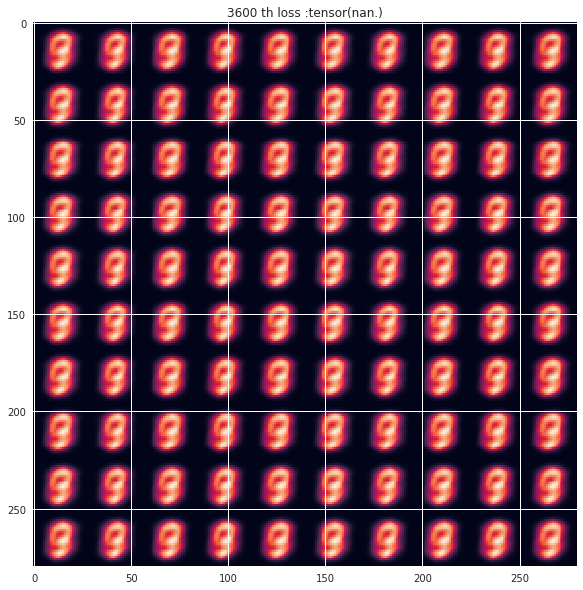

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


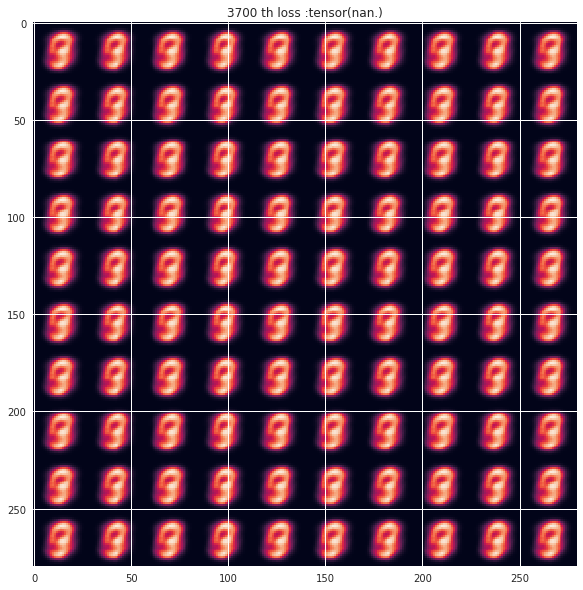

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


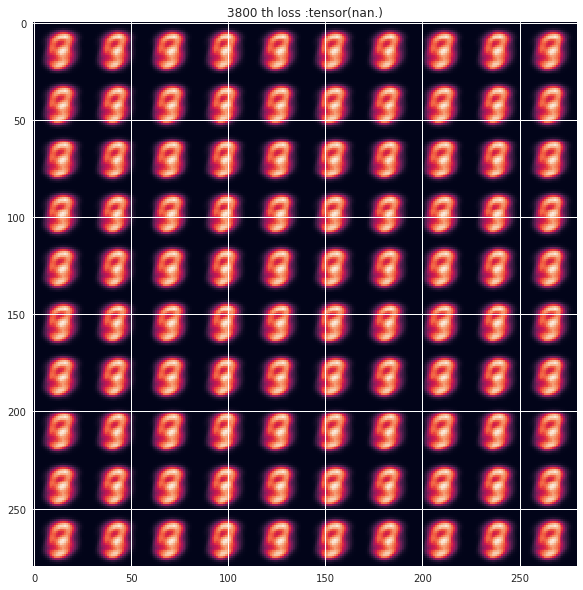

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


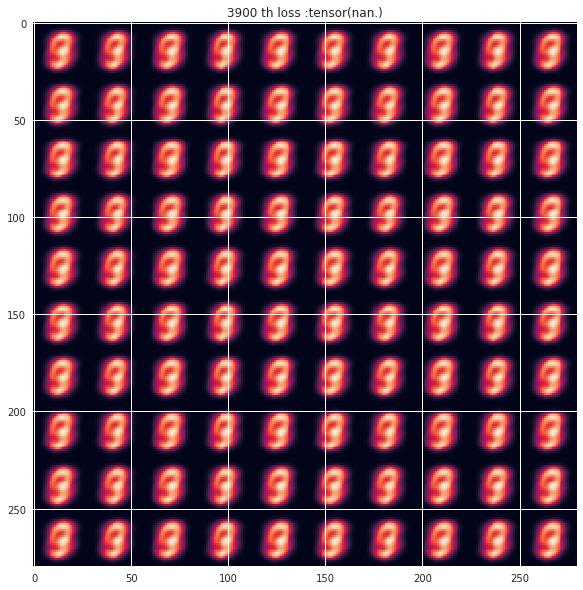

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


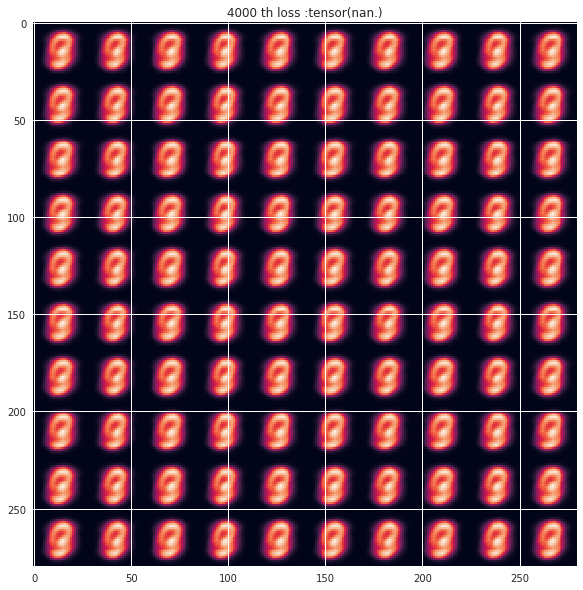

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


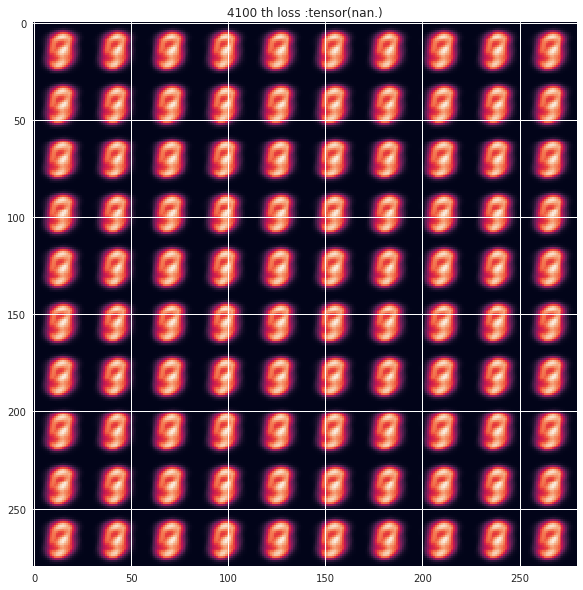

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


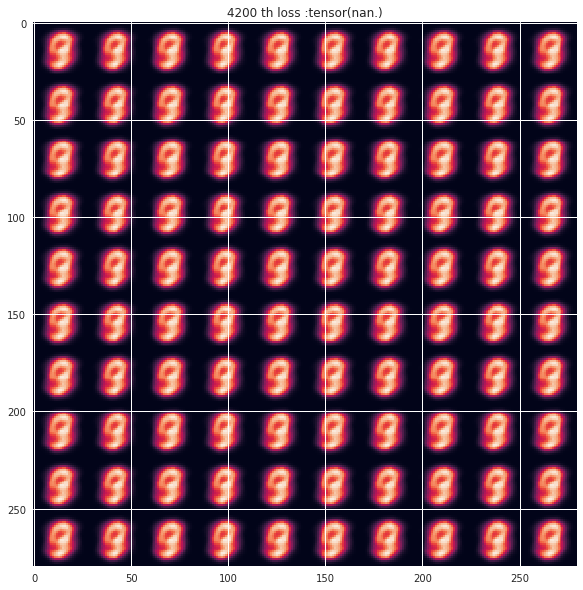

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


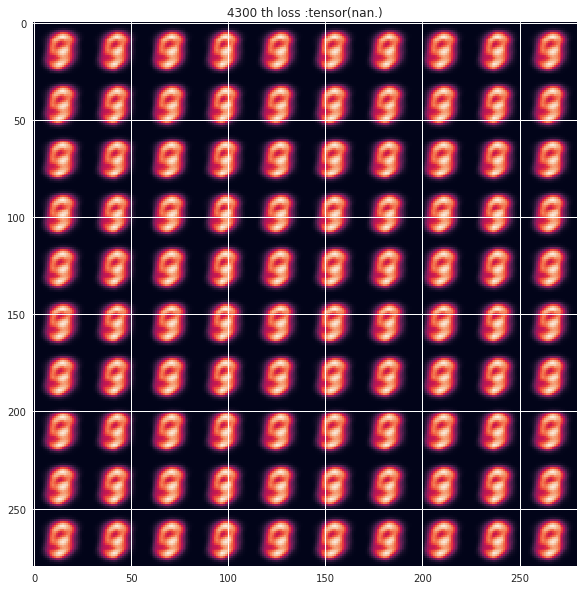

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


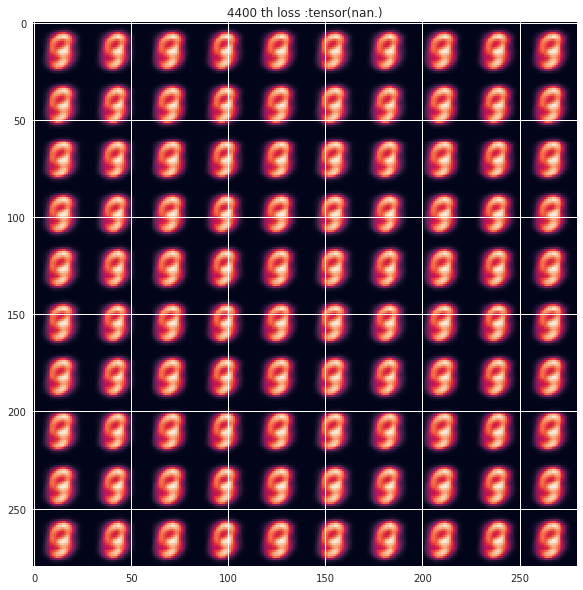

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


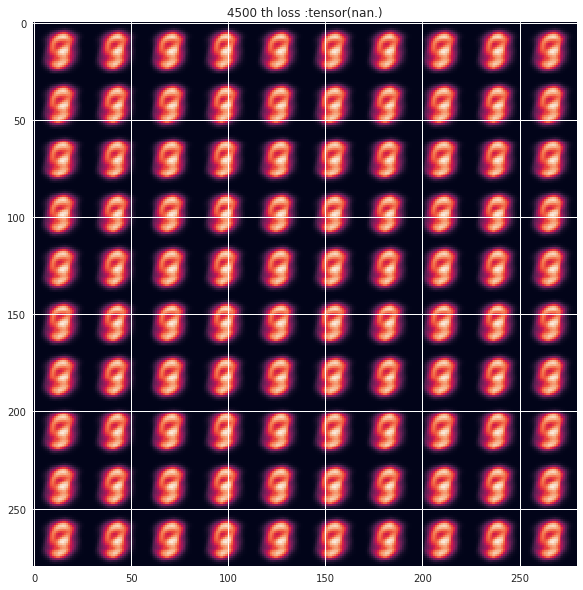

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


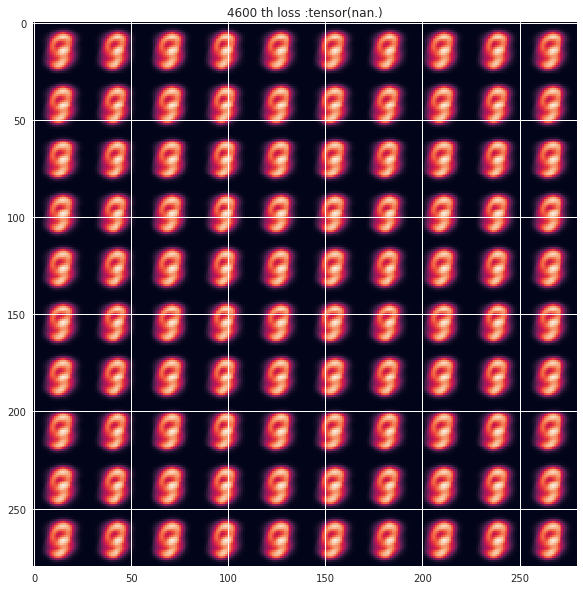

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


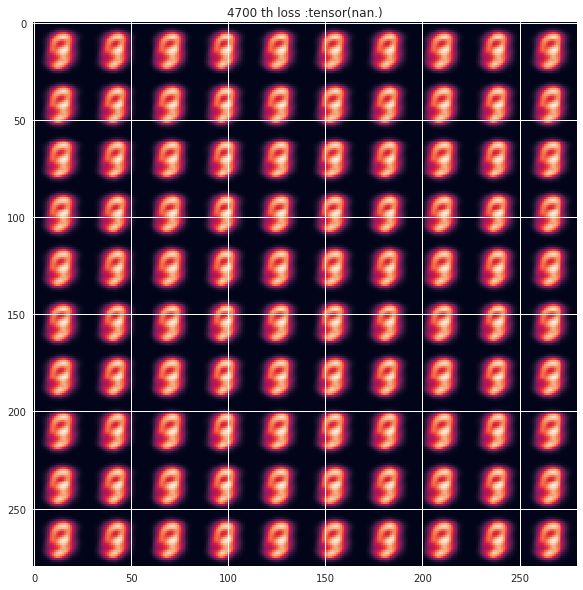

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


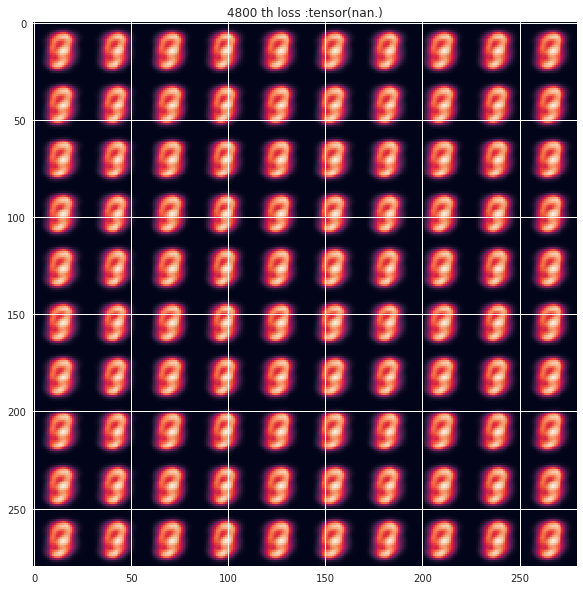

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


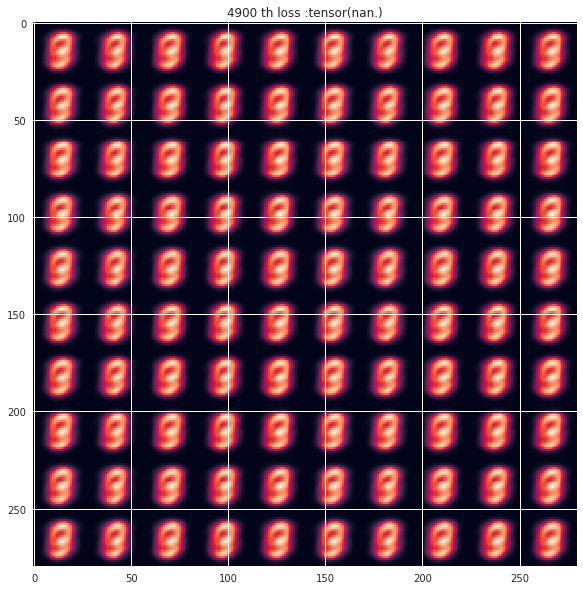

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


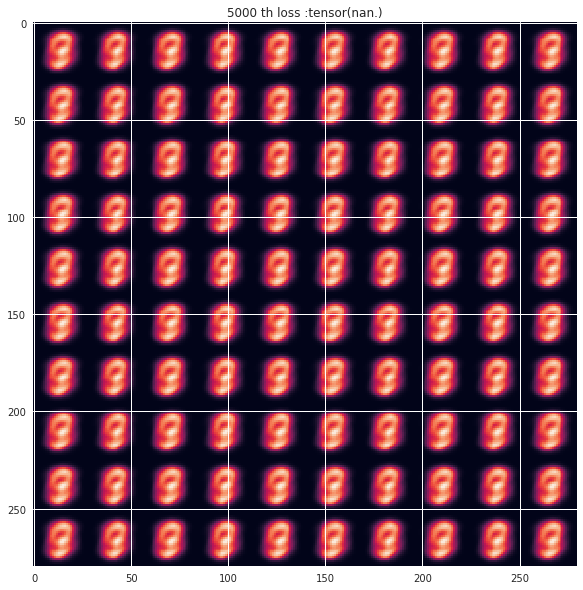

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


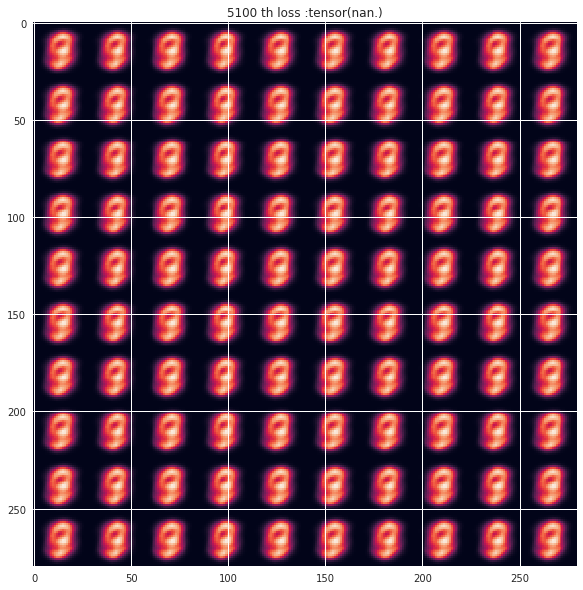

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


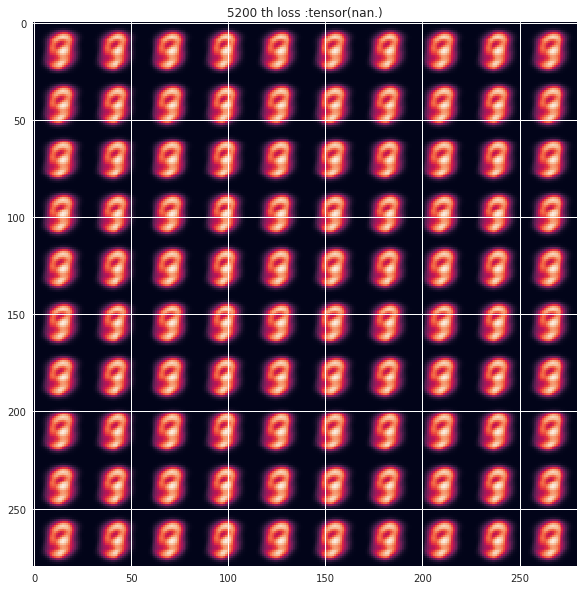

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


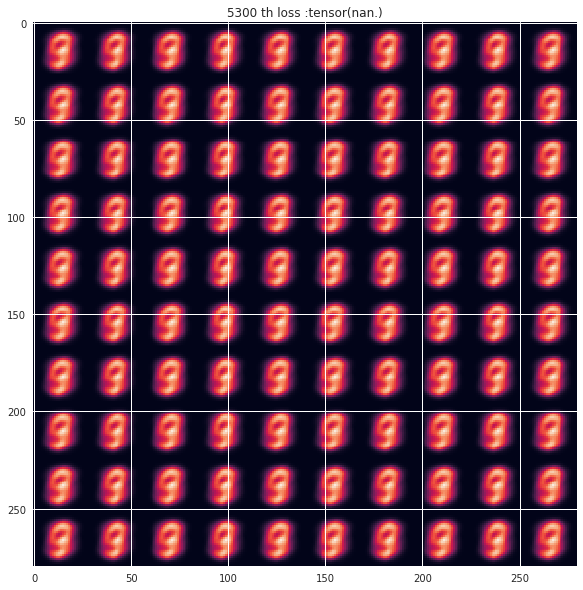

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


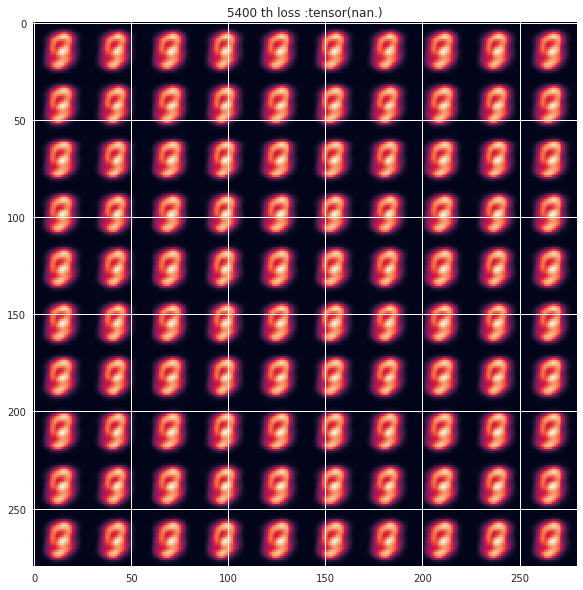

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


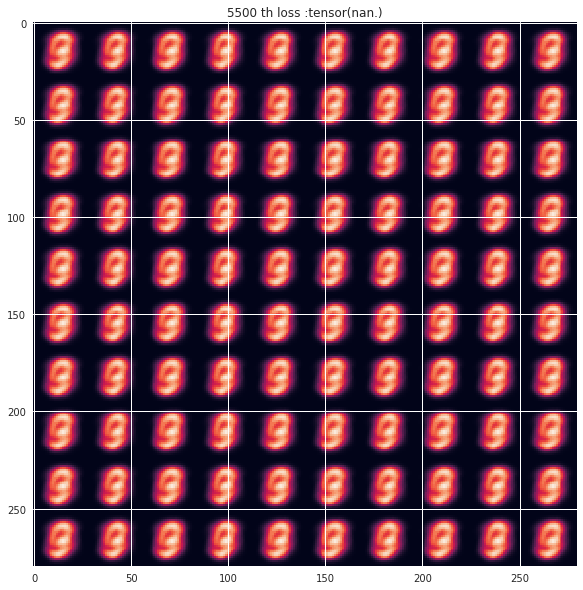

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


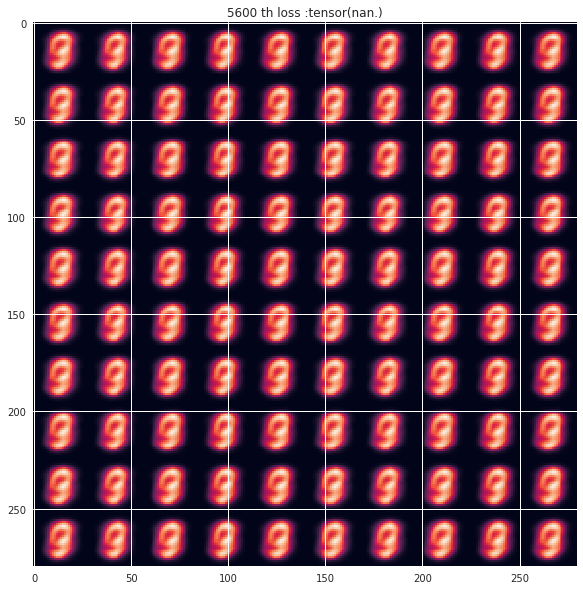

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


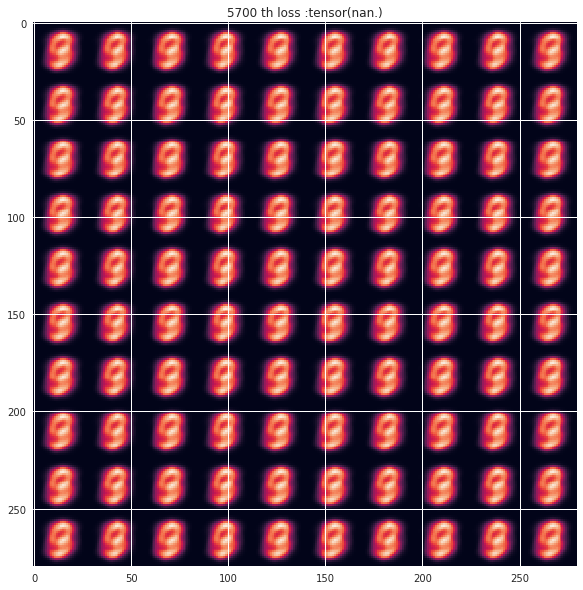

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


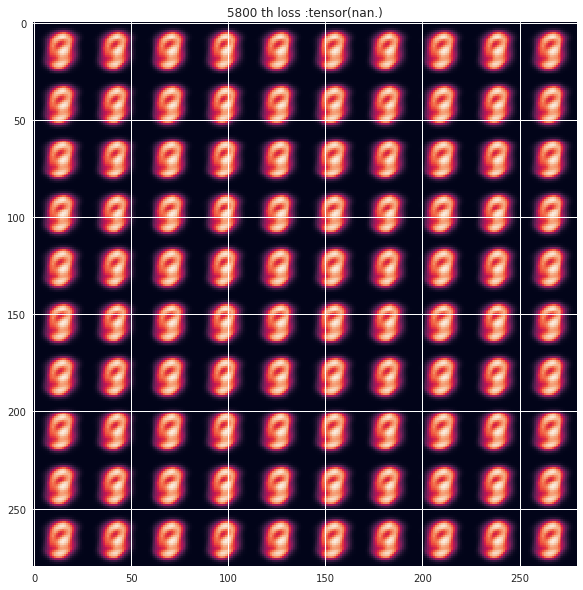

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


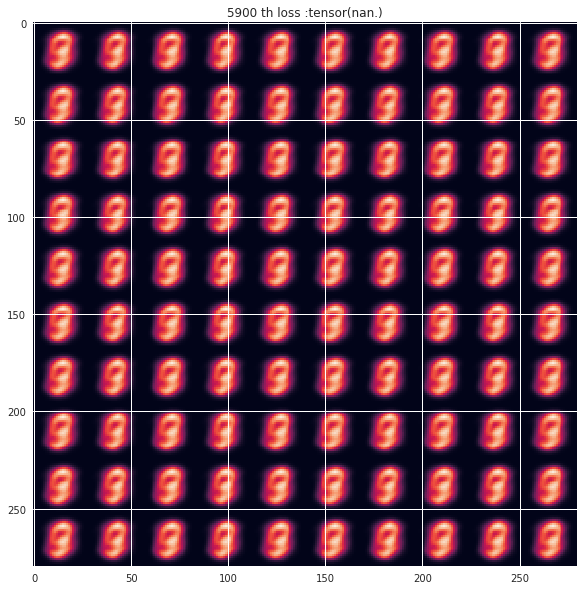

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


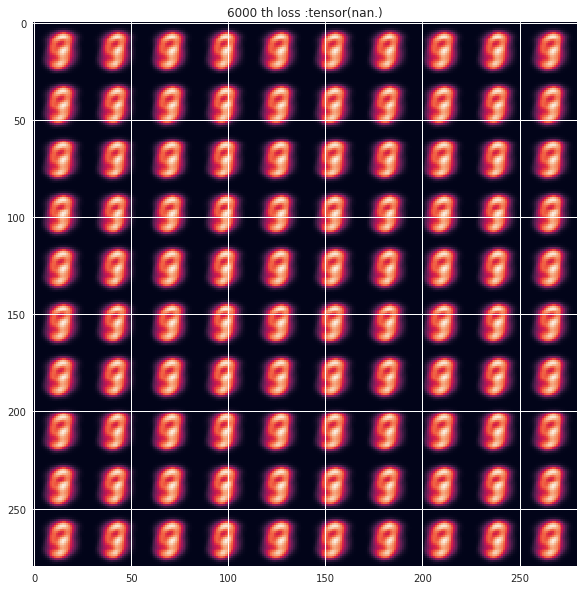

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


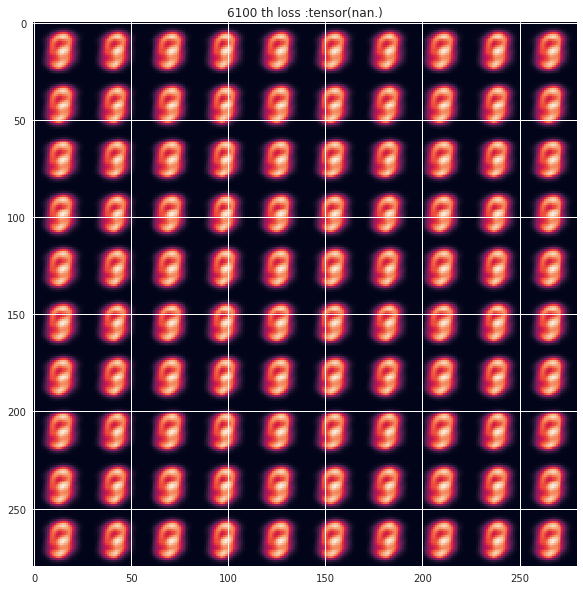

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


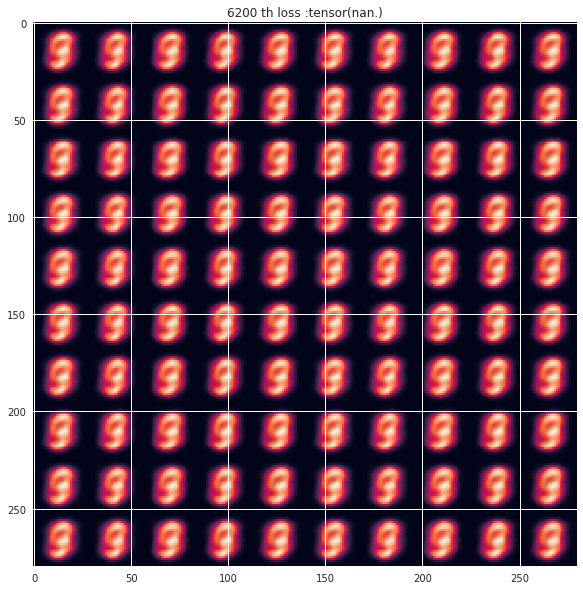

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


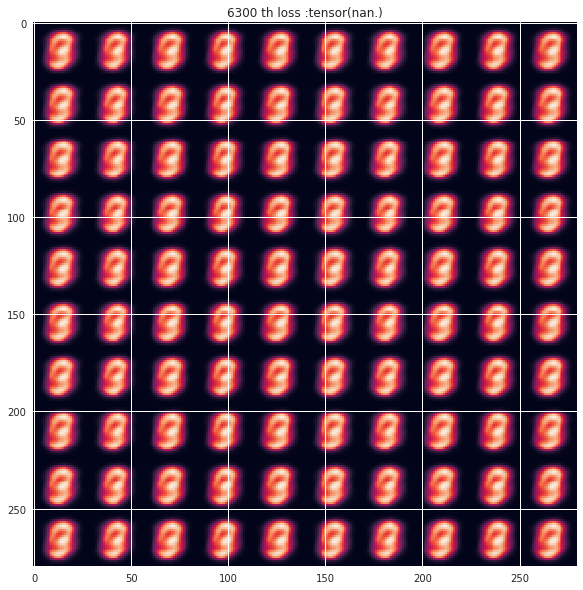

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


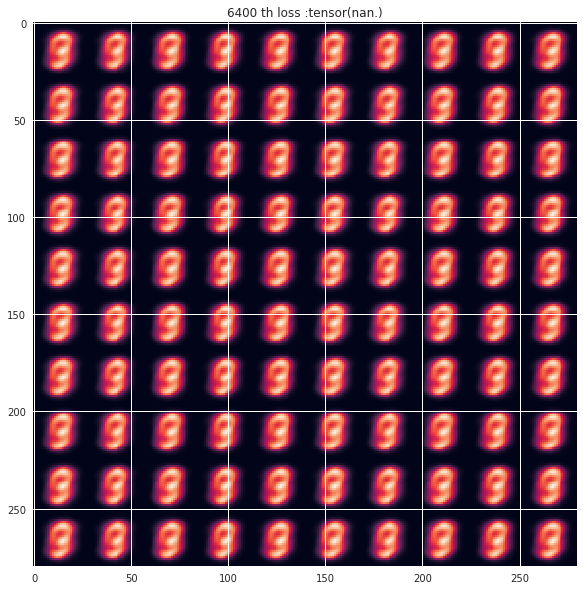

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


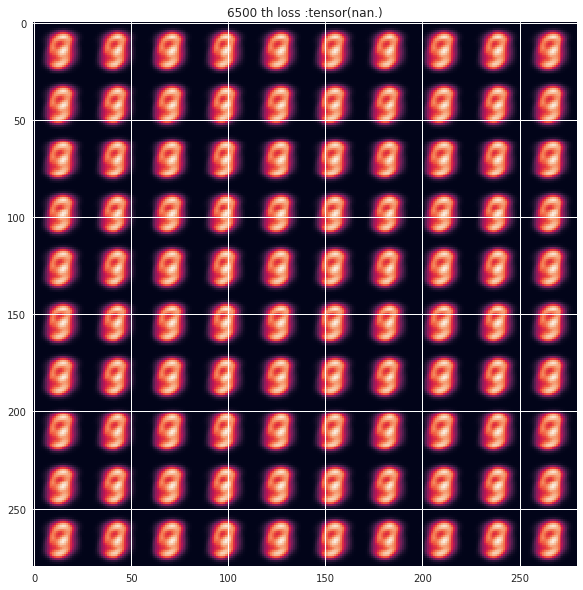

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


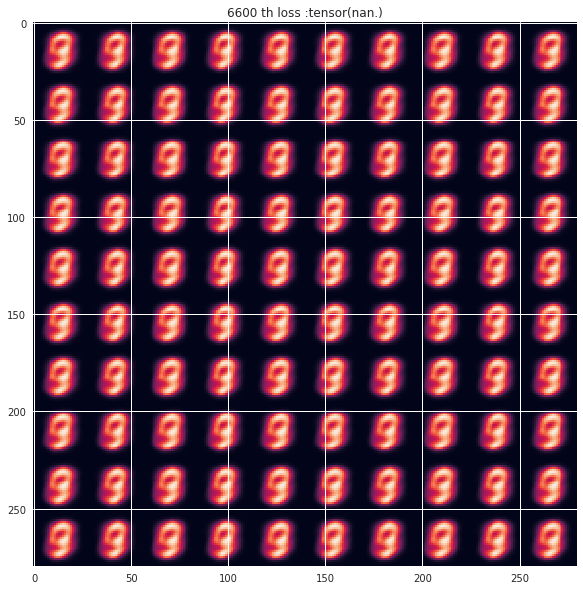

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


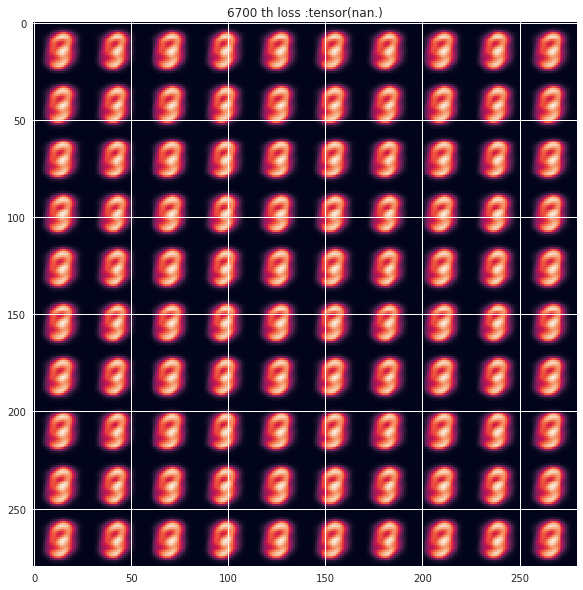

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


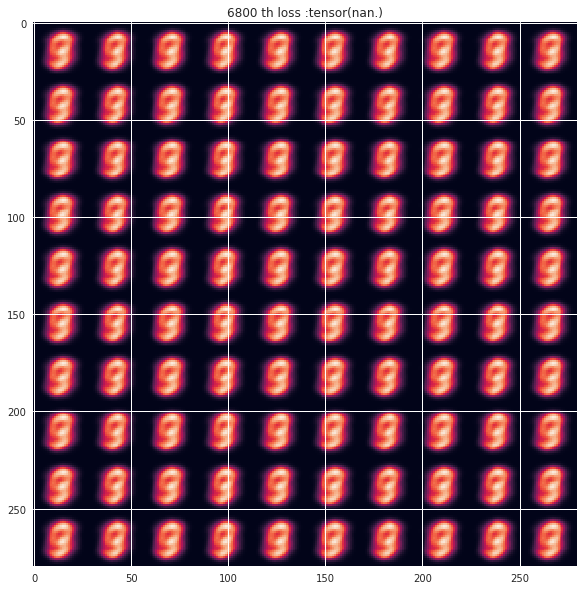

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


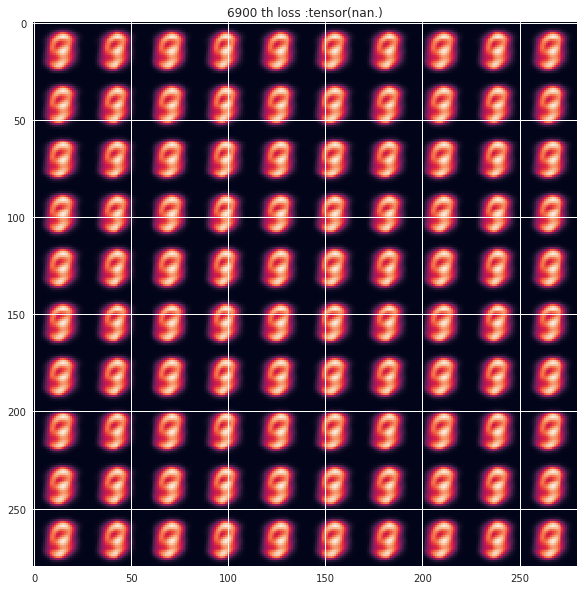

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


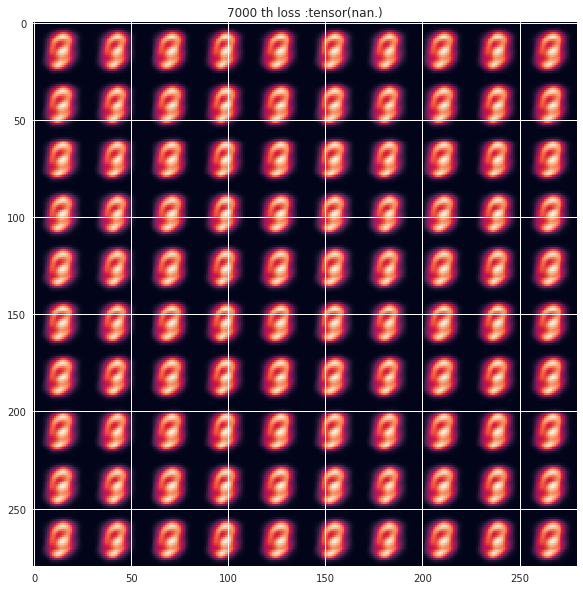

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


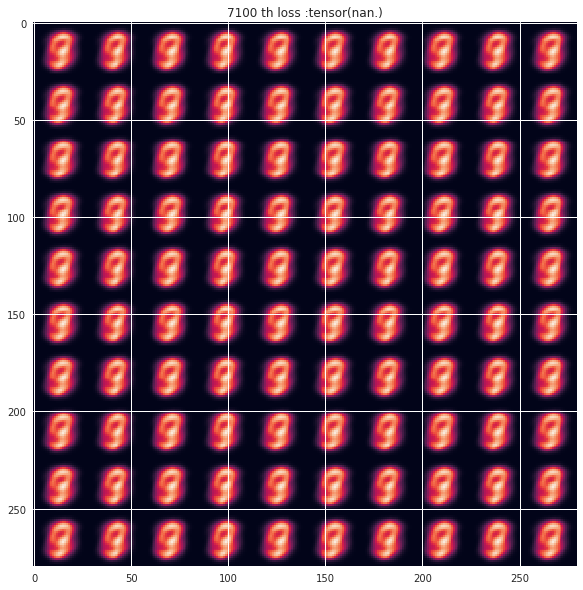

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


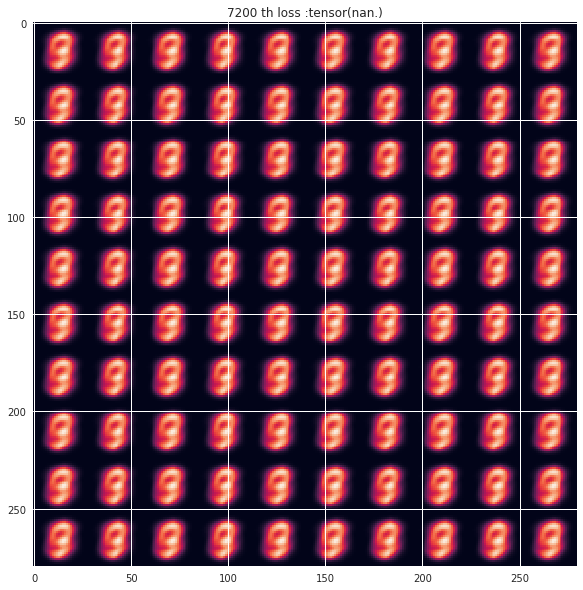

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


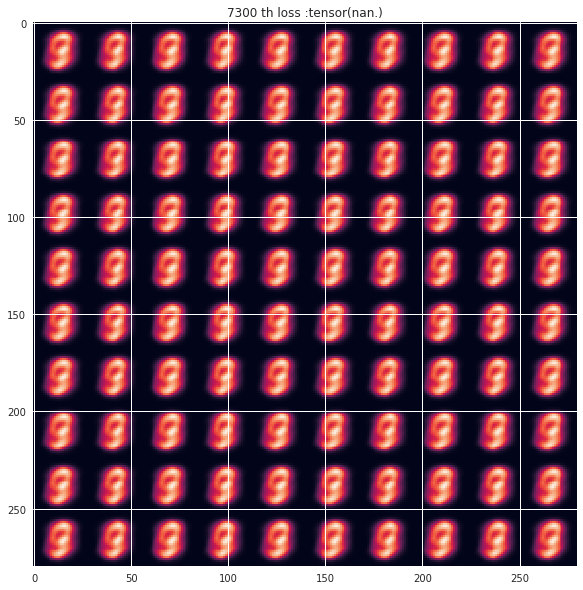

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


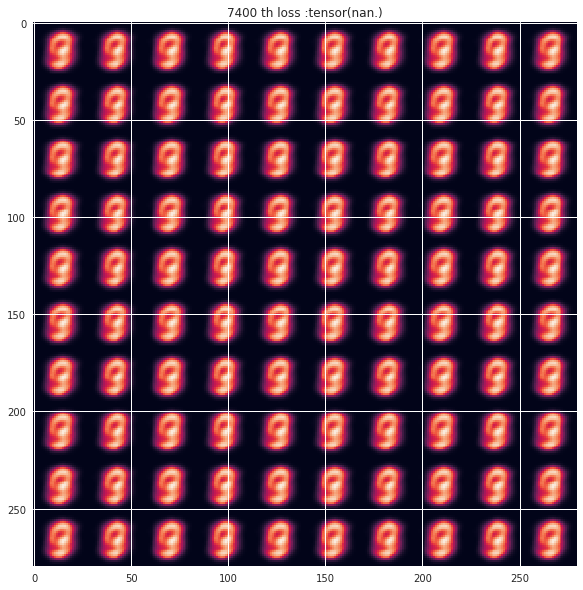

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


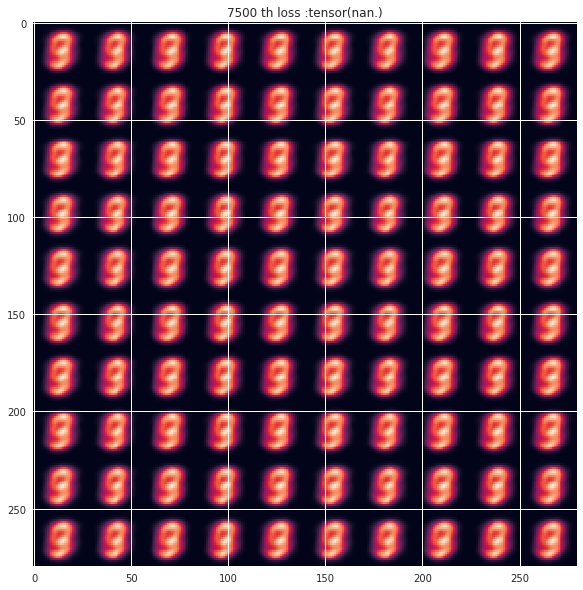

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


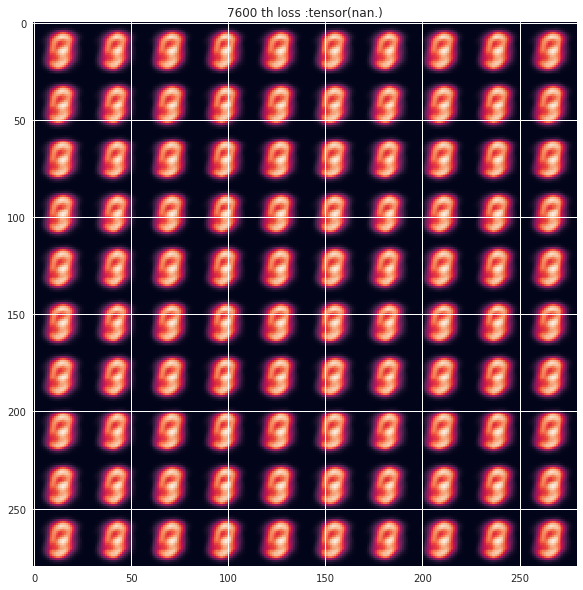

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


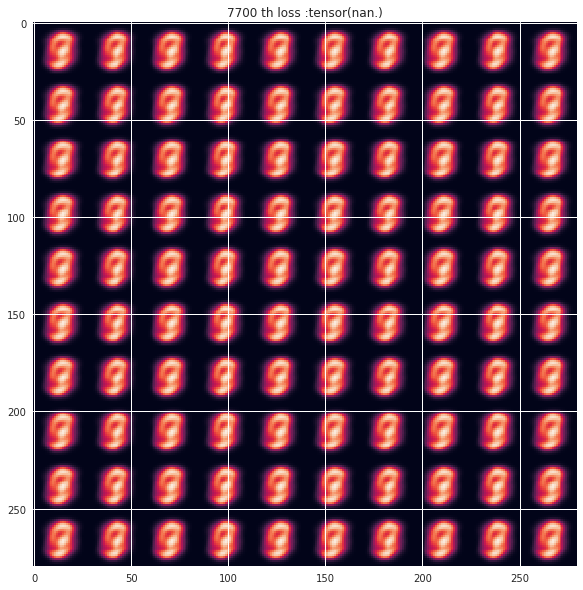

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


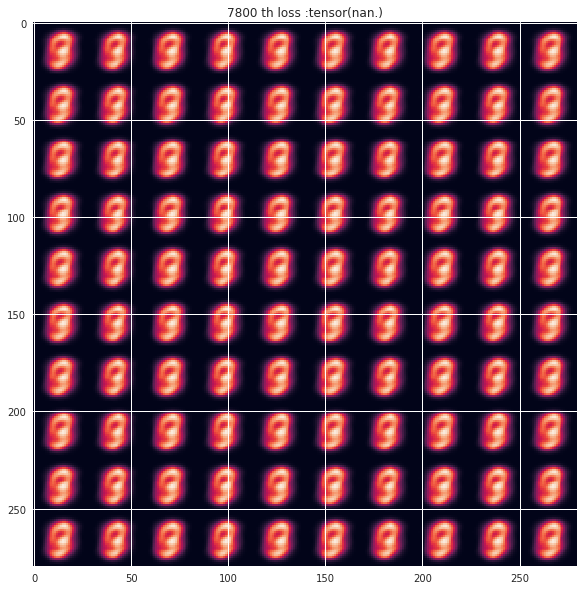

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


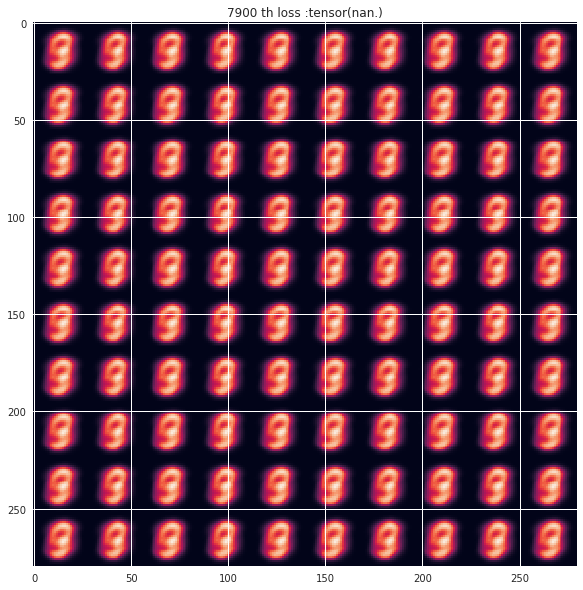

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


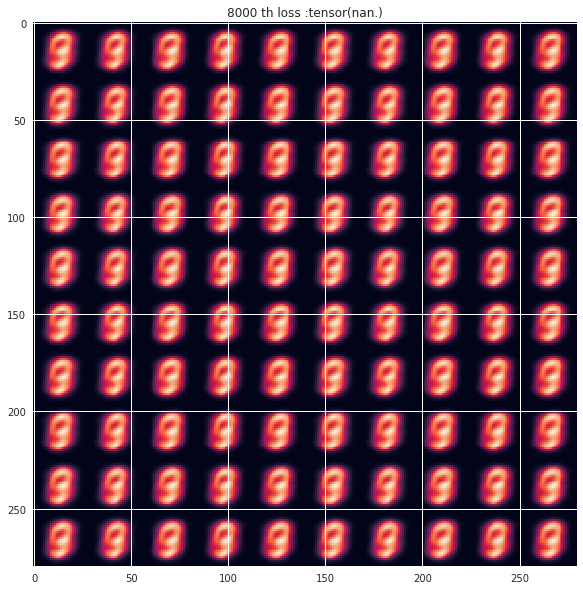

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


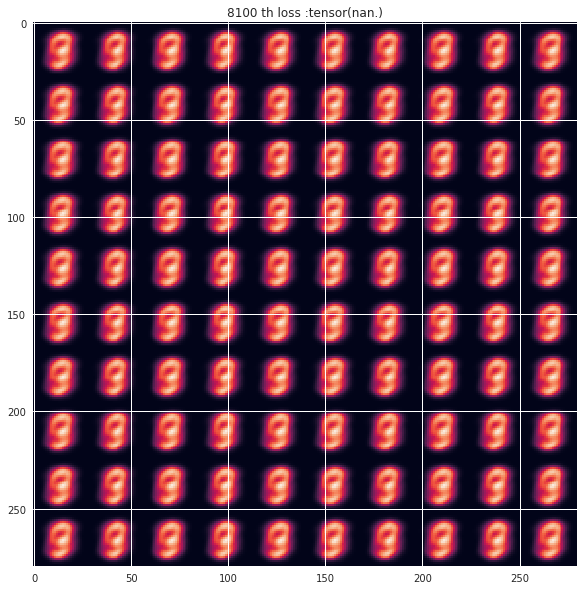

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


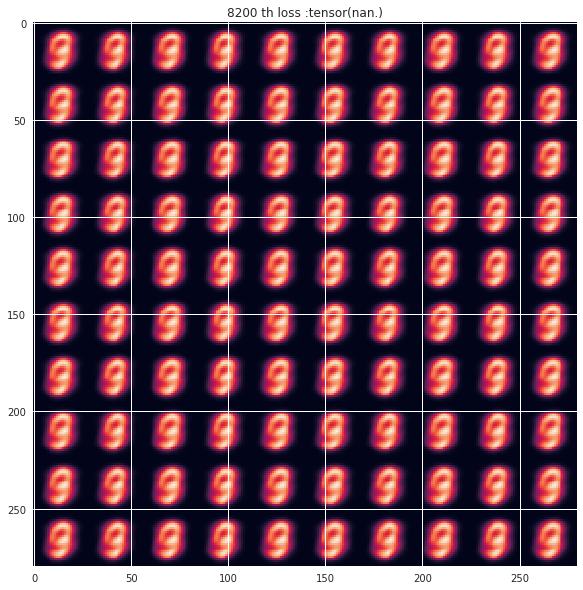

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


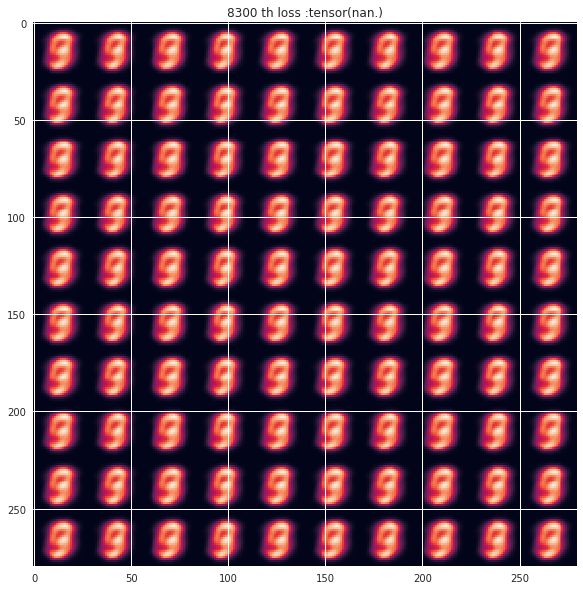

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


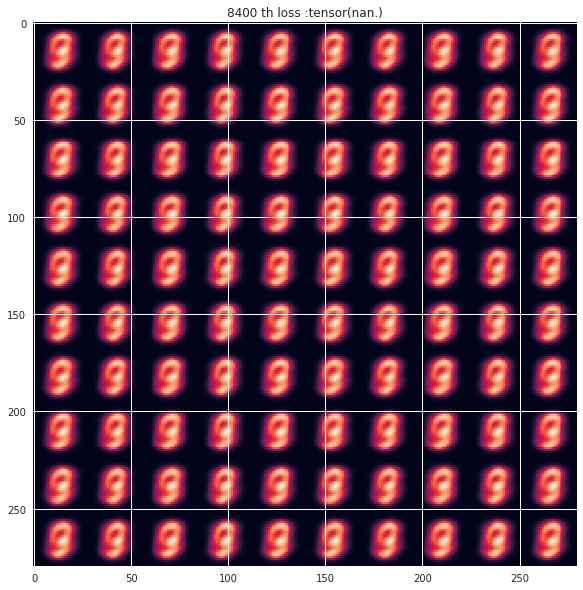

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


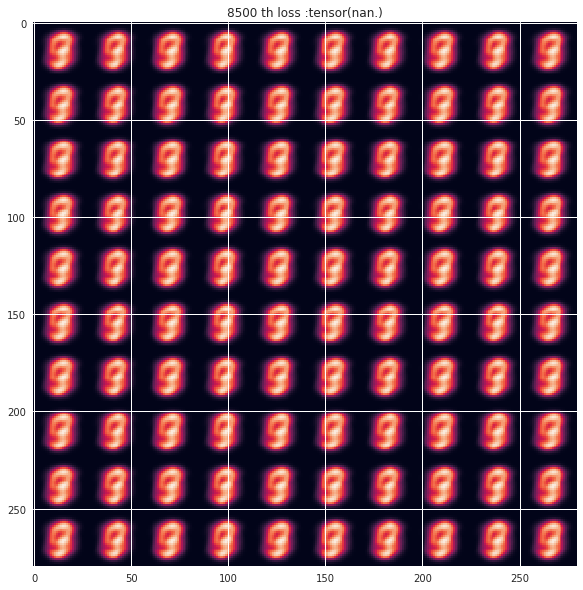

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


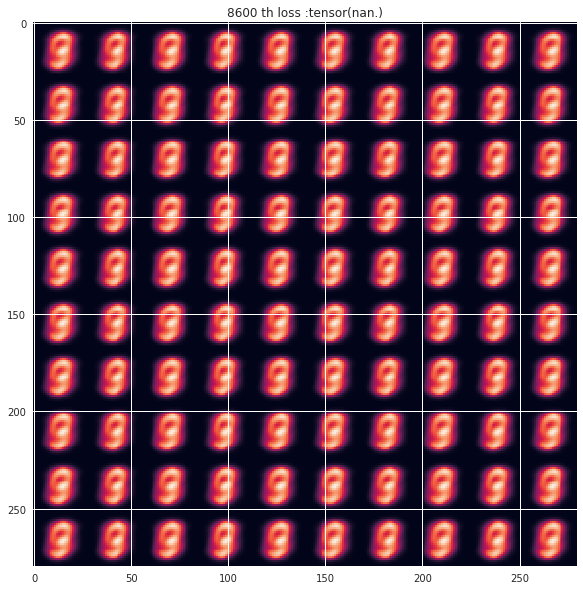

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


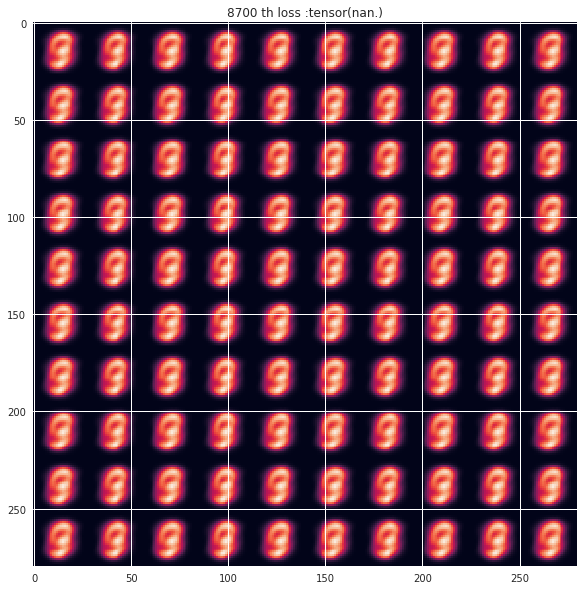

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


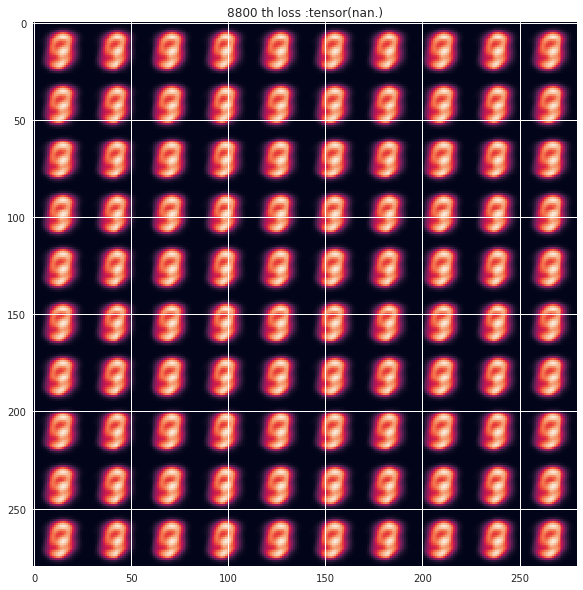

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


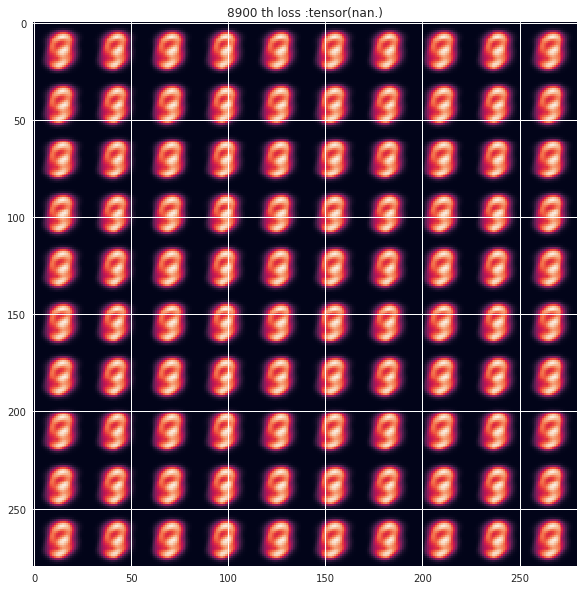

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


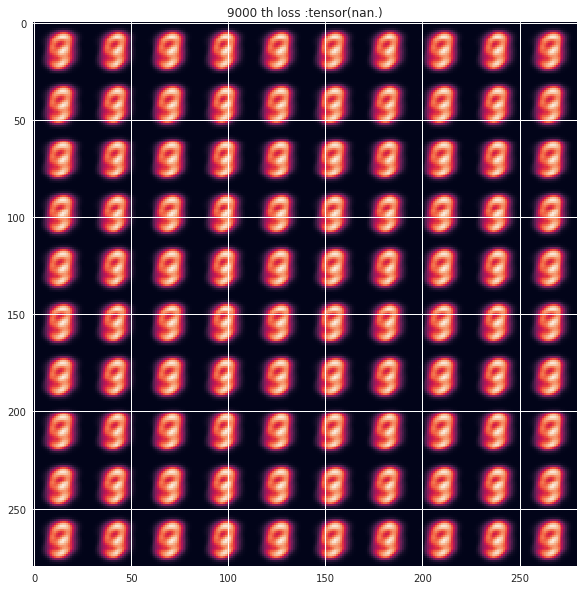

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


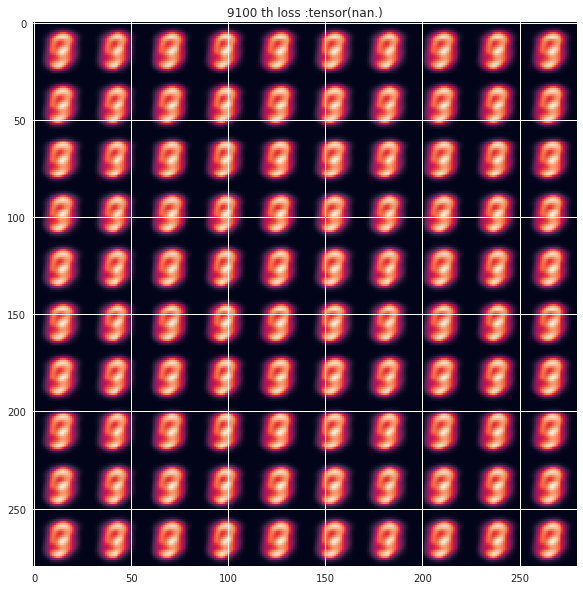

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


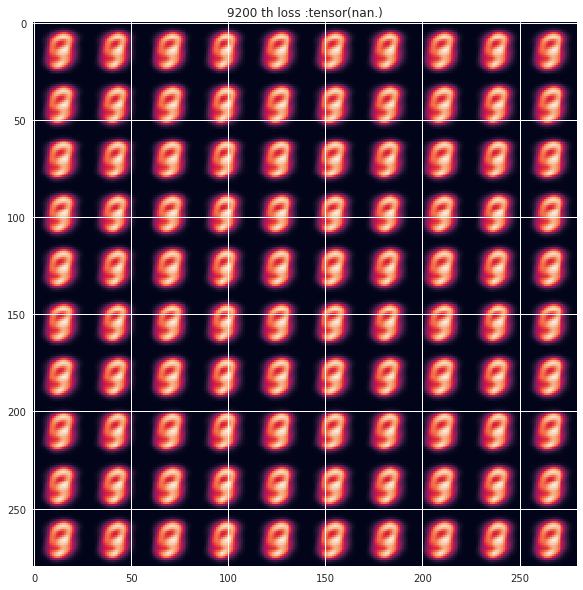

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


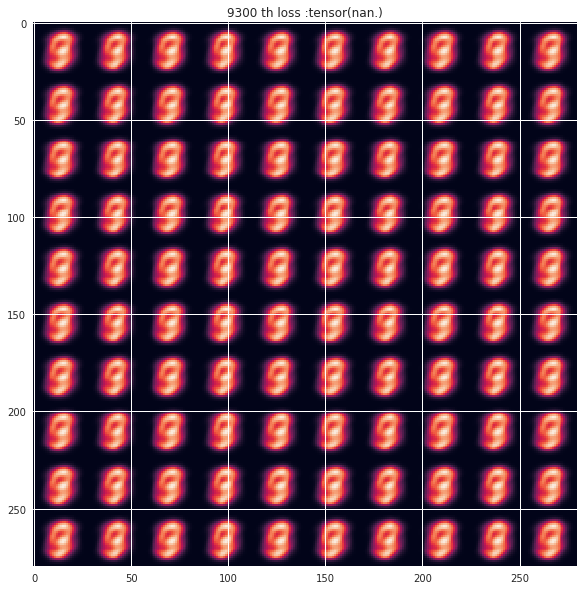

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


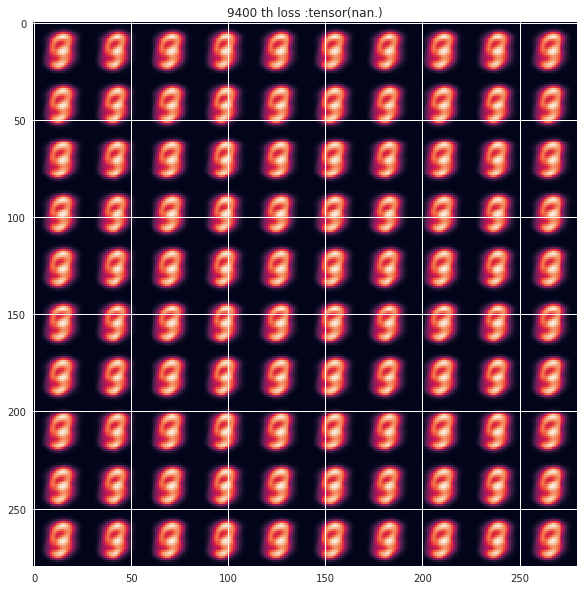

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


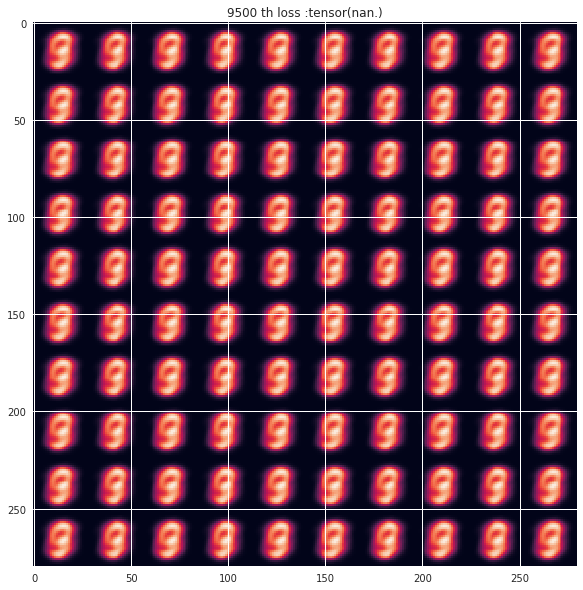

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


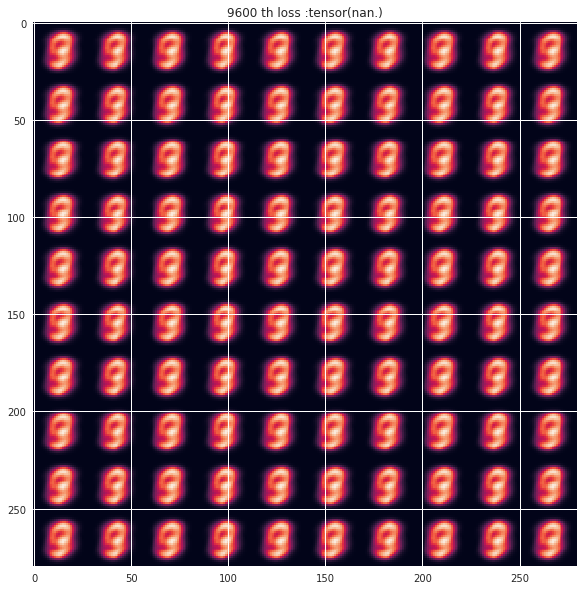

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


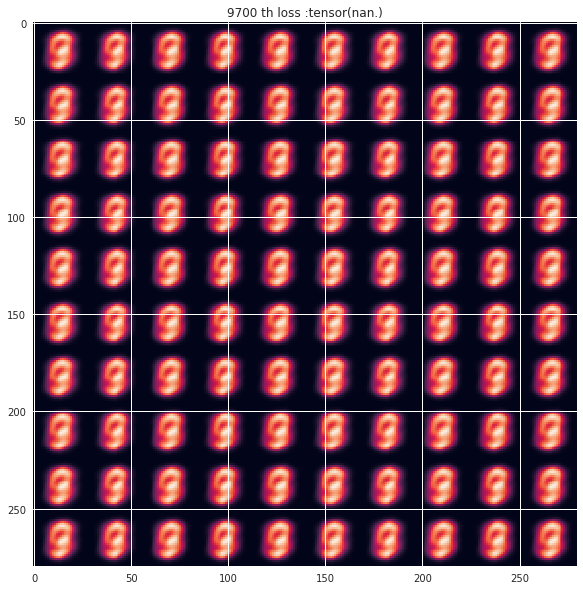

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


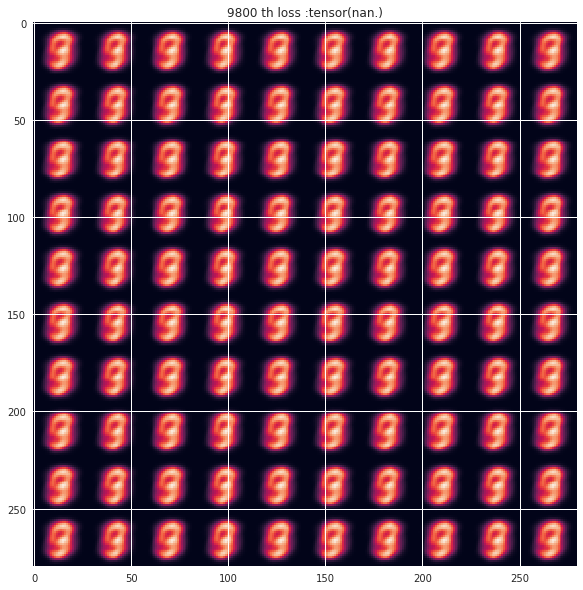

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


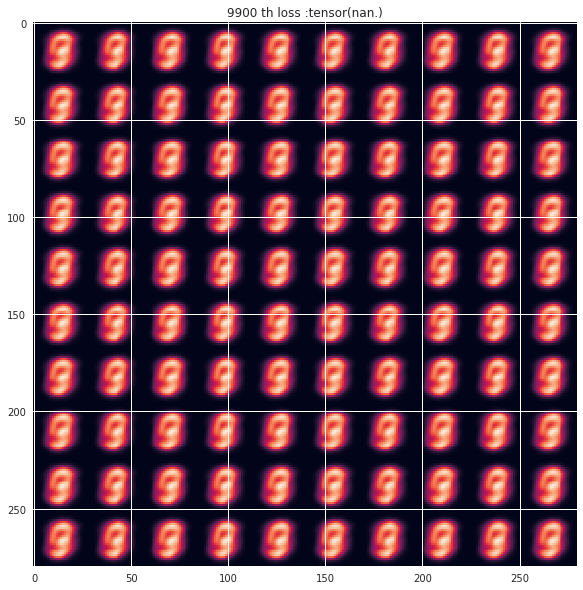

SF
tensor(nan., device='cuda:0')
PD
tensor(nan., device='cuda:0')


In [9]:
video_path = './naive_score.mp4'
writer = skvideo.io.FFmpegWriter(video_path)
losses = list()

for i in range(NUM_ITERS):
    np_x, np_y = data.next_batch(BATCH_SIZE)
    np_x = Variable(torch.FloatTensor(np_x)).cuda()
    q_y = en(np_x)
    
    u = torch.rand((BATCH_SIZE, N*K)).cuda()
    v = torch.rand((BATCH_SIZE, N*K)).cuda()
    
    b_soft = F.softmax(sample_z(u.view(-1,1), q_y.view(-1,1)).view(-1,K)/LAMBDA, dim=1)
    b, ind = H(sample_z(u.view(-1,1), q_y.view(-1,1)).view(-1,K))
    b_soft_cond = F.softmax(sample_zb(v.view(-1,1), q_y.view(-1,1),\
                                      b.view(-1,1).detach(), ind.detach()).view(-1,K)/LAMBDA, dim=1)
#     print('qy')
#     print(q_y[:10])
#     print('v')
#     print(v[0][:10])
#     print('b')
#     print(b[0])
#     print('b_soft')
#     print(b_soft[0])
#     print('ind')
#     print(ind[0])
#     print('b_soft_cond')
#     print(b_soft_cond[0])
    
    elbo_b, logits_b = compute_elbo(b, np_x, q_y.view(-1,N*K))
    elbo_b_soft, logits_b_soft = compute_elbo(b_soft, np_x, q_y.view(-1,N*K))
    elbo_b_soft_cond, logits_b_soft_cond = compute_elbo(b_soft_cond, np_x, q_y.view(-1,N*K))
    
#     print(elbo_b[0])
#     print(elbo_b_soft[0])
#     print(elbo_b_soft_cond[0])
    
    cov = np.cov(np.vstack((elbo_b.data.cpu().view(-1).numpy(), elbo_b_soft.data.cpu().view(-1).numpy())))
    ETA = float(cov[0][1]/cov[1][1])
    
    log_like = (torch.log(q_y).view(-1,N*K) * b.view(-1,N*K)).sum(dim=1)
    SF = (-1* ( elbo_b  ).detach() * log_like).mean()
    PD = (-1 * ETA * ( elbo_b_soft - elbo_b_soft_cond )).mean()
    elbo_b_, logits_b_ = compute_elbo(b, np_x, q_y.view(-1,N*K))

    loss =  SF - elbo_b_.mean()
    
    en_opt.zero_grad()
    de_opt.zero_grad()
    loss.backward()
    en_opt.step()
    de_opt.step()
    
    l = elbo_b.cpu().data.mean()
    losses.append(l)
    
    if (i%100)==0:
        # make figure
        fig = plt.figure()
        x_img = F.sigmoid(logits_b.data).view(10,10,28,28)
        # split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
        x_img = np.concatenate(np.split(x_img,10,axis=0),axis=3)
        # split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
        x_img = np.concatenate(np.split(x_img,10,axis=1),axis=2)
        x_img = np.squeeze(x_img)
        plt.imshow(x_img)
        
        plt.title(str(i)+' th loss :'+ str(l))
        fig.canvas.draw()

        # Get the RGBA buffer from the figure
        w,h = fig.canvas.get_width_height()
        buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
        buf.shape = (h, w, 4)
        plot = buf[:, :, 1:]
        plt.show()
        plt.close()
        outputframe = np.zeros((h, w, 3))
        outputframe[:, :] = plot
        writer.writeFrame(outputframe)
        
        print('SF')
        print(SF)
        print('PD')
        print(PD)
    
writer.close()

In [10]:
video = io.open('./naive_score.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

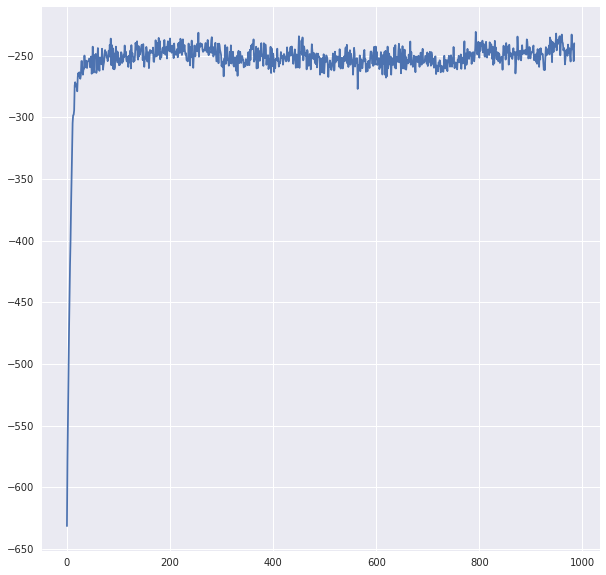

In [11]:
plt.plot(range(len(losses)), losses)
plt.show()